<a href="https://colab.research.google.com/github/Wb-az/COVID-19-classification/blob/main/airbnb_paris_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Machine Learning</center></h1>


<h2><center> Airbnb Data Analysis and Price Prediction Quarters Q2-Q4 2022 </center> </h2>



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import subprocess
# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [3]:
%pip -q install pandas

In [4]:
%pip install -q scikit-learn

In [5]:
%pip install -q scipy

In [6]:
%pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 5.5 MB/s eta 0:00:00


In [7]:
%pip install -q joblib

In [9]:
%pip install -q geopandas
%pip install -q contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 33.7 MB/s eta 0:00:00


In [10]:
%pip install -q missingno

In [11]:
%pip install -q xgboost

In [12]:
%pip install -q lightgbm

In [284]:
%pip install -q ydata-profiling

In [14]:
# %%capture
# !pip install --upgrade dpcpp_cpp_rt

In [15]:
%%capture
!pip install scikit-learn-intelex
!pip install fasttreeshap

In [16]:
%%capture
!pip install torch

In [17]:
#  change directory
%cd '/content/drive/MyDrive/airbnb'

/content/drive/MyDrive/airbnb


## 1. Introduction

__Airbnb__, Inc. is an American San Francisco-based company operating an online marketplace for short-term homestays and experiences. The company acts as a broker and charges a commission from each booking.  The company not only have revolutionized the tourism industry but have also facilitated an unaffordable increase in home rents due to a lack of regulation (https://en.wikipedia.org/wiki/Airbnb).

With this in mind, the objectives of this project are:

* Visualise the properties offered in the 20 Arrondissements of Paris during Quarters Q2 - Q4 of 2022
* Select features that impact the price of a listing
* Identify potential inactive listing with outlier prices - noise
* Identify the most expensive and cheapest neighbourhoods
* Identify the type of accommodations and properties more often offered by Airbnb
* Identify listings that offered for long-term stays
* Find the model that best predicts the listing prices
* Compute Shapley number for the feature of the best model explainability (XAI)


Airbnb datasets Q2-Q4 2022 can be sourced from  http://insideairbnb.com/get-the-data/

The tasks below will be undertaken in this version:

- Drop highly __correlated reviews__
- The average of the __highly correlated reviews__ scores will be added as a new column in the data frame
- Produce a __Profile Report__ of the hot-encoded and scaled data using pandas __profiler__.
  Note: uncomment the cell to run the test
- Accelerate Scikit-learn models training by using intel ```scikit-learn-intelex```
- Use the latest __version of XGBoost__ running on __CPU__
- Apply __max-min scaling__ to features and price
- Training will be done on the __training dataset__ and performance tested on the __validation dataset__
- __Statistical comparison__ of the performance of the best top training models using the non-parametric __Kruskal-Wallis__ __H-test__ to test the null hypothesis. In addition, the __Kolmogorov-Smirnov__ test for goodness of fit will be used for pairwise comparison of the top models.
- The __grid search__ optimisation will use the training and validation datasets and the __performance__ of the best model will be measured on the __test subset__.
- The __SHAP__ values will be computed for the best model on the test dataset

### 1.1 Libraries and frameworks

In [18]:
import os, gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import joblib
import missingno as msno
from pandas.tseries.offsets import DateOffset
from sklearnex import patch_sklearn
patch_sklearn()
# from daal4py.oneapi import sycl_context#
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.compose import make_column_transformer,TransformedTargetRegressor
from sklearn.feature_selection import mutual_info_regression, SelectPercentile, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR
# metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
    mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from skorch import NeuralNetRegressor

import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(123)
torch.cuda.manual_seed(123)
sns.set_style(style='white')
%matplotlib inline


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## 2. Dataset

### 2.1 Creating directory for datasets and downlading data

In [19]:
paris_dir = os.path.join(os.getcwd(), 'datasets', 'paris')
try:
    os.makedirs(paris_dir, exist_ok=False)
except OSError as error:
    print('Directory already exist')

Directory already exist


In [20]:
# Creat directory to save figures
plots_dir = os.path.join(os.getcwd(), 'figures')
try:
    os.makedirs(plots_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')


Directory already exist


### 2.2 Frequenty function clean data and save plots

In [21]:
# Drop columns and rows functions
def drop_columns(col_list=None, df=None):

    df.drop(col_list, axis=1, inplace=True)

def drop_rows(indices=None, df=None):
    df.drop(index=indices, inplace=True)


In [177]:
def save_plot(plot_name, x=None, y=None, close=True):
    plt.xlabel(x)
    plt.ylabel(y)
    plt.savefig(os.path.join(plots_dir, f'{plot_name}.jpg'), bbox_inches='tight',
                        format='jpg')
    if close:
        return plt.close()

### 2.3 Download the data

The dasets for q2, q3 and q4 will be dowloaded an concatenated.

In [23]:
# Uncomment to download
download = False
if download:
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/data/listings.csv.gz -O 'datasets/paris/listings_q4.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q4.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-12-10/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q4.csv'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/data/listings.csv.gz -O 'datasets/paris/listings_q3.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q3.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-09-09/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q3.csv'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/data/listings.csv.gz -O 'datasets/paris/listings_q2.csv.gz'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/visualisations/neighbourhoods.geojson -O 'datasets/paris/neighbourhoods_q2.geojson'
    !wget http://data.insideairbnb.com/france/ile-de-france/paris/2022-06-06/visualisations/neighbourhoods.csv -O 'datasets/paris/neighbourhoods_q2.csv'


### 2.4 Load datasets from csv file

In [24]:
df_q2 = pd.read_csv(os.path.join(paris_dir, 'listings_q2.csv.gz'), compression='gzip')
df_q3 = pd.read_csv(os.path.join(paris_dir, 'listings_q3.csv.gz'), compression='gzip')
df_q4 = pd.read_csv(os.path.join(paris_dir, 'listings_q4.csv.gz'), compression='gzip')

In [25]:
# Extract the number of features in each quarter
f2 = df_q2.columns
f3 = df_q3.columns
f4 = df_q4.columns

print(f'Are the features in df_q2 equal to the features in df_q3? {len(f2) == len(f3)}')
print(f'Are the features in df_q3 equal to the features in df_q4? {len(f3) == len(f4)}')

Are the features in df_q2 equal to the features in df_q3? False
Are the features in df_q3 equal to the features in df_q4? True


In [26]:
# find the features in df_q3 that are not in df_q2
drop_cols= list()
for f in f3:
    if f not in f2:
        print(f'drop column: "{f}" from df_q3 and df_q4')
        drop_cols.append(f)

drop column: "source" from df_q3 and df_q4


In [27]:
# Drop column source to concatenate the three datsets in one
for c in drop_cols:
    df_q3.drop(c, axis=1, inplace=True)
    df_q4.drop(c, axis=1, inplace=True)

df_paris = pd.concat([df_q2, df_q3, df_q4], ignore_index=True)
print(f'Dataset features: {len(df_paris)}')


Dataset features: 173208


In [28]:
def data_summary(df, plot_dir=plots_dir, name=None):
    """
    Function to summarise features and properties with missing features
    """

    # find unique listings by id
    properties = len(df.id.unique())

    # find the number of features with nan values per accommodation
    nan_per_accomodation = df.isna().sum(axis=1)

    # Uniquenumber of features missing
    missing_features = np.unique(nan_per_accomodation)

    print(f'Accomodations: {len(df)} | Unique accomodations: {properties}')
    print(f'Dataset features including id: {len(df.columns)} | \
    Accomodations missing features: {len(nan_per_accomodation)}')

    # Visualise the distribution of properties per missing features
    if 0 in nan_per_accomodation.value_counts().keys():
         nan_per_accomodation.value_counts()[1:].plot.bar(color='green', fontsize=10, figsize=(5,3))

    else:
        nan_per_accomodation.value_counts().plot.bar(color='green', fontsize=10, figsize=(5,3))
    plt.title('Missing features in accommodation')
    plt.ylabel('listings count')
    plt.xlabel('missing features')
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'{name}.jpg'), bbox_inches='tight',
                    format='jpg')
    plt.close()

    return nan_per_accomodation, missing_features


In [29]:
print('======== Summary before data cleaning, wrangling and data engineering ========')
missing_features, unique_misses = data_summary(df_paris, name='init-hist')


======== Summary before data cleaning, wrangling and data engineering ========
Accomodations: 173208 | Unique accomodations: 73122
Dataset features including id: 74 |     Accomodations missing features: 173208


 <img align="left" src='figures/init-hist.jpg' width=500/>

In [30]:
df_paris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173208 entries, 0 to 173207
Data columns (total 74 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   id                                            173208 non-null  int64  
 1   listing_url                                   173208 non-null  object 
 2   scrape_id                                     173208 non-null  int64  
 3   last_scraped                                  173208 non-null  object 
 4   name                                          173086 non-null  object 
 5   description                                   171099 non-null  object 
 6   neighborhood_overview                         100156 non-null  object 
 7   picture_url                                   173205 non-null  object 
 8   host_id                                       173208 non-null  int64  
 9   host_url                                      17

**Plot here**

<img src='figures/init-hist.jpg' width='400'/>

- Unique Accommodations 73122 in Q2-Q4
- All accomodations 173208
- All listing have at least one feture missing.
- Most of the listing miss 20 or less features,


## 3. Visualisation of listings spread in Paris

In [31]:
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
import contextily as cx

- Only visualise the unique properties advertise in Q2-Q4 2022
- Use geopandas, folium and context geo tiles (contextily) to read  and visualise the geolocation of each neighbourhood
- plot the propertieslocation

### 3.1 Interactive localisation - GIS

In [32]:
property_gis = df_paris.copy()[['id', 'neighbourhood_cleansed','latitude', 'longitude',
                      'price']]
property_gis.drop_duplicates(subset='id', inplace=True)
gis = gpd.read_file(os.path.join(paris_dir, 'neighbourhoods_q4.geojson'))

In [33]:
acc_coords = property_gis[['latitude', 'longitude']].values.tolist()
coord_size = len(acc_coords)

In [34]:
paris_coor = [48.85341, 2.3488]

paris_map = folium.Map(location=paris_coor, tiles='openstreetmap',
                       zoom_start=11)

for i, geo in enumerate(gis.geometry.values):
    geo_j = folium.GeoJson(data=geo,
                       style_function=lambda x:{'fillColor': 'blue'})
    folium.Popup(gis.neighbourhood[i]).add_to(geo_j)
    geo_j.add_to(paris_map)
FastMarkerCluster(acc_coords, radius=0.5).add_to(paris_map)
paris_map.save(os.path.join(plots_dir, 'geomap.html'))


In [35]:
paris_map

### 3.2  Mercador location coordinates  of  the listings and neighboourhoods

In [36]:
def listings_gis(df, col_name='neighbourhood', title=None, plot_name=None, coordinates=None):

    gdf = gpd.GeoDataFrame(df, crs=4326, geometry=gpd.points_from_xy(df.longitude,
                                                df.latitude))
    # Convert coordinates to Mercador coordinates
    neigh=coordinates.to_crs(epsg=3857)
    listings=gdf.to_crs(epsg=3857)
    ax=neigh.plot(column=col_name, alpha=0.7, legend=True,
                cmap='tab20', figsize=(20, 20), edgecolor='black')
    listings.plot(ax=ax, alpha=0.2, color='blue', marker='o', markersize=2,
                          figsize=(20, 20), legend=False)
    cx.add_basemap(ax)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.savefig(os.path.join(plots_dir, f'{plot_name}.jpg'), bbox_inches='tight',
                        format='jpg')
    plt.close()


In [37]:
title = 'Listing distribution in Paris Neighbourhoods'
gis_name = 'paris_listings'
listings_gis(property_gis, col_name='neighbourhood', title=title, plot_name=gis_name,
             coordinates=gis)

In [38]:
(property_gis.neighbourhood_cleansed.value_counts()/len(property_gis)).plot.bar(color='green', fontsize=8,
                                                            figsize=(5, 3))
plt.grid()
save_plot('neighbourhood_listings', x='neighbourhood_cleansed', y='listings density')

**To see the map and bar chart uncomment the markdown code in this cell**
<img align="left" src='figures/paris_listings.jpg' width=500/><img align="right" src='figures/neighbourhood_listings.jpg' width=350/>



## 4. Features exploration data analysis

### 4.1 Summary of features

In [39]:
# Convert strings to dates
date_time_cols = ['host_since', 'first_review', 'last_review', 'last_scraped',
                  'calendar_last_scraped']
df_paris[date_time_cols] = df_paris[date_time_cols].apply(pd.to_datetime)

In [40]:
# Types of data in the dataset
df_paris.dtypes.value_counts()

object            29
float64           23
int64             17
datetime64[ns]     5
dtype: int64

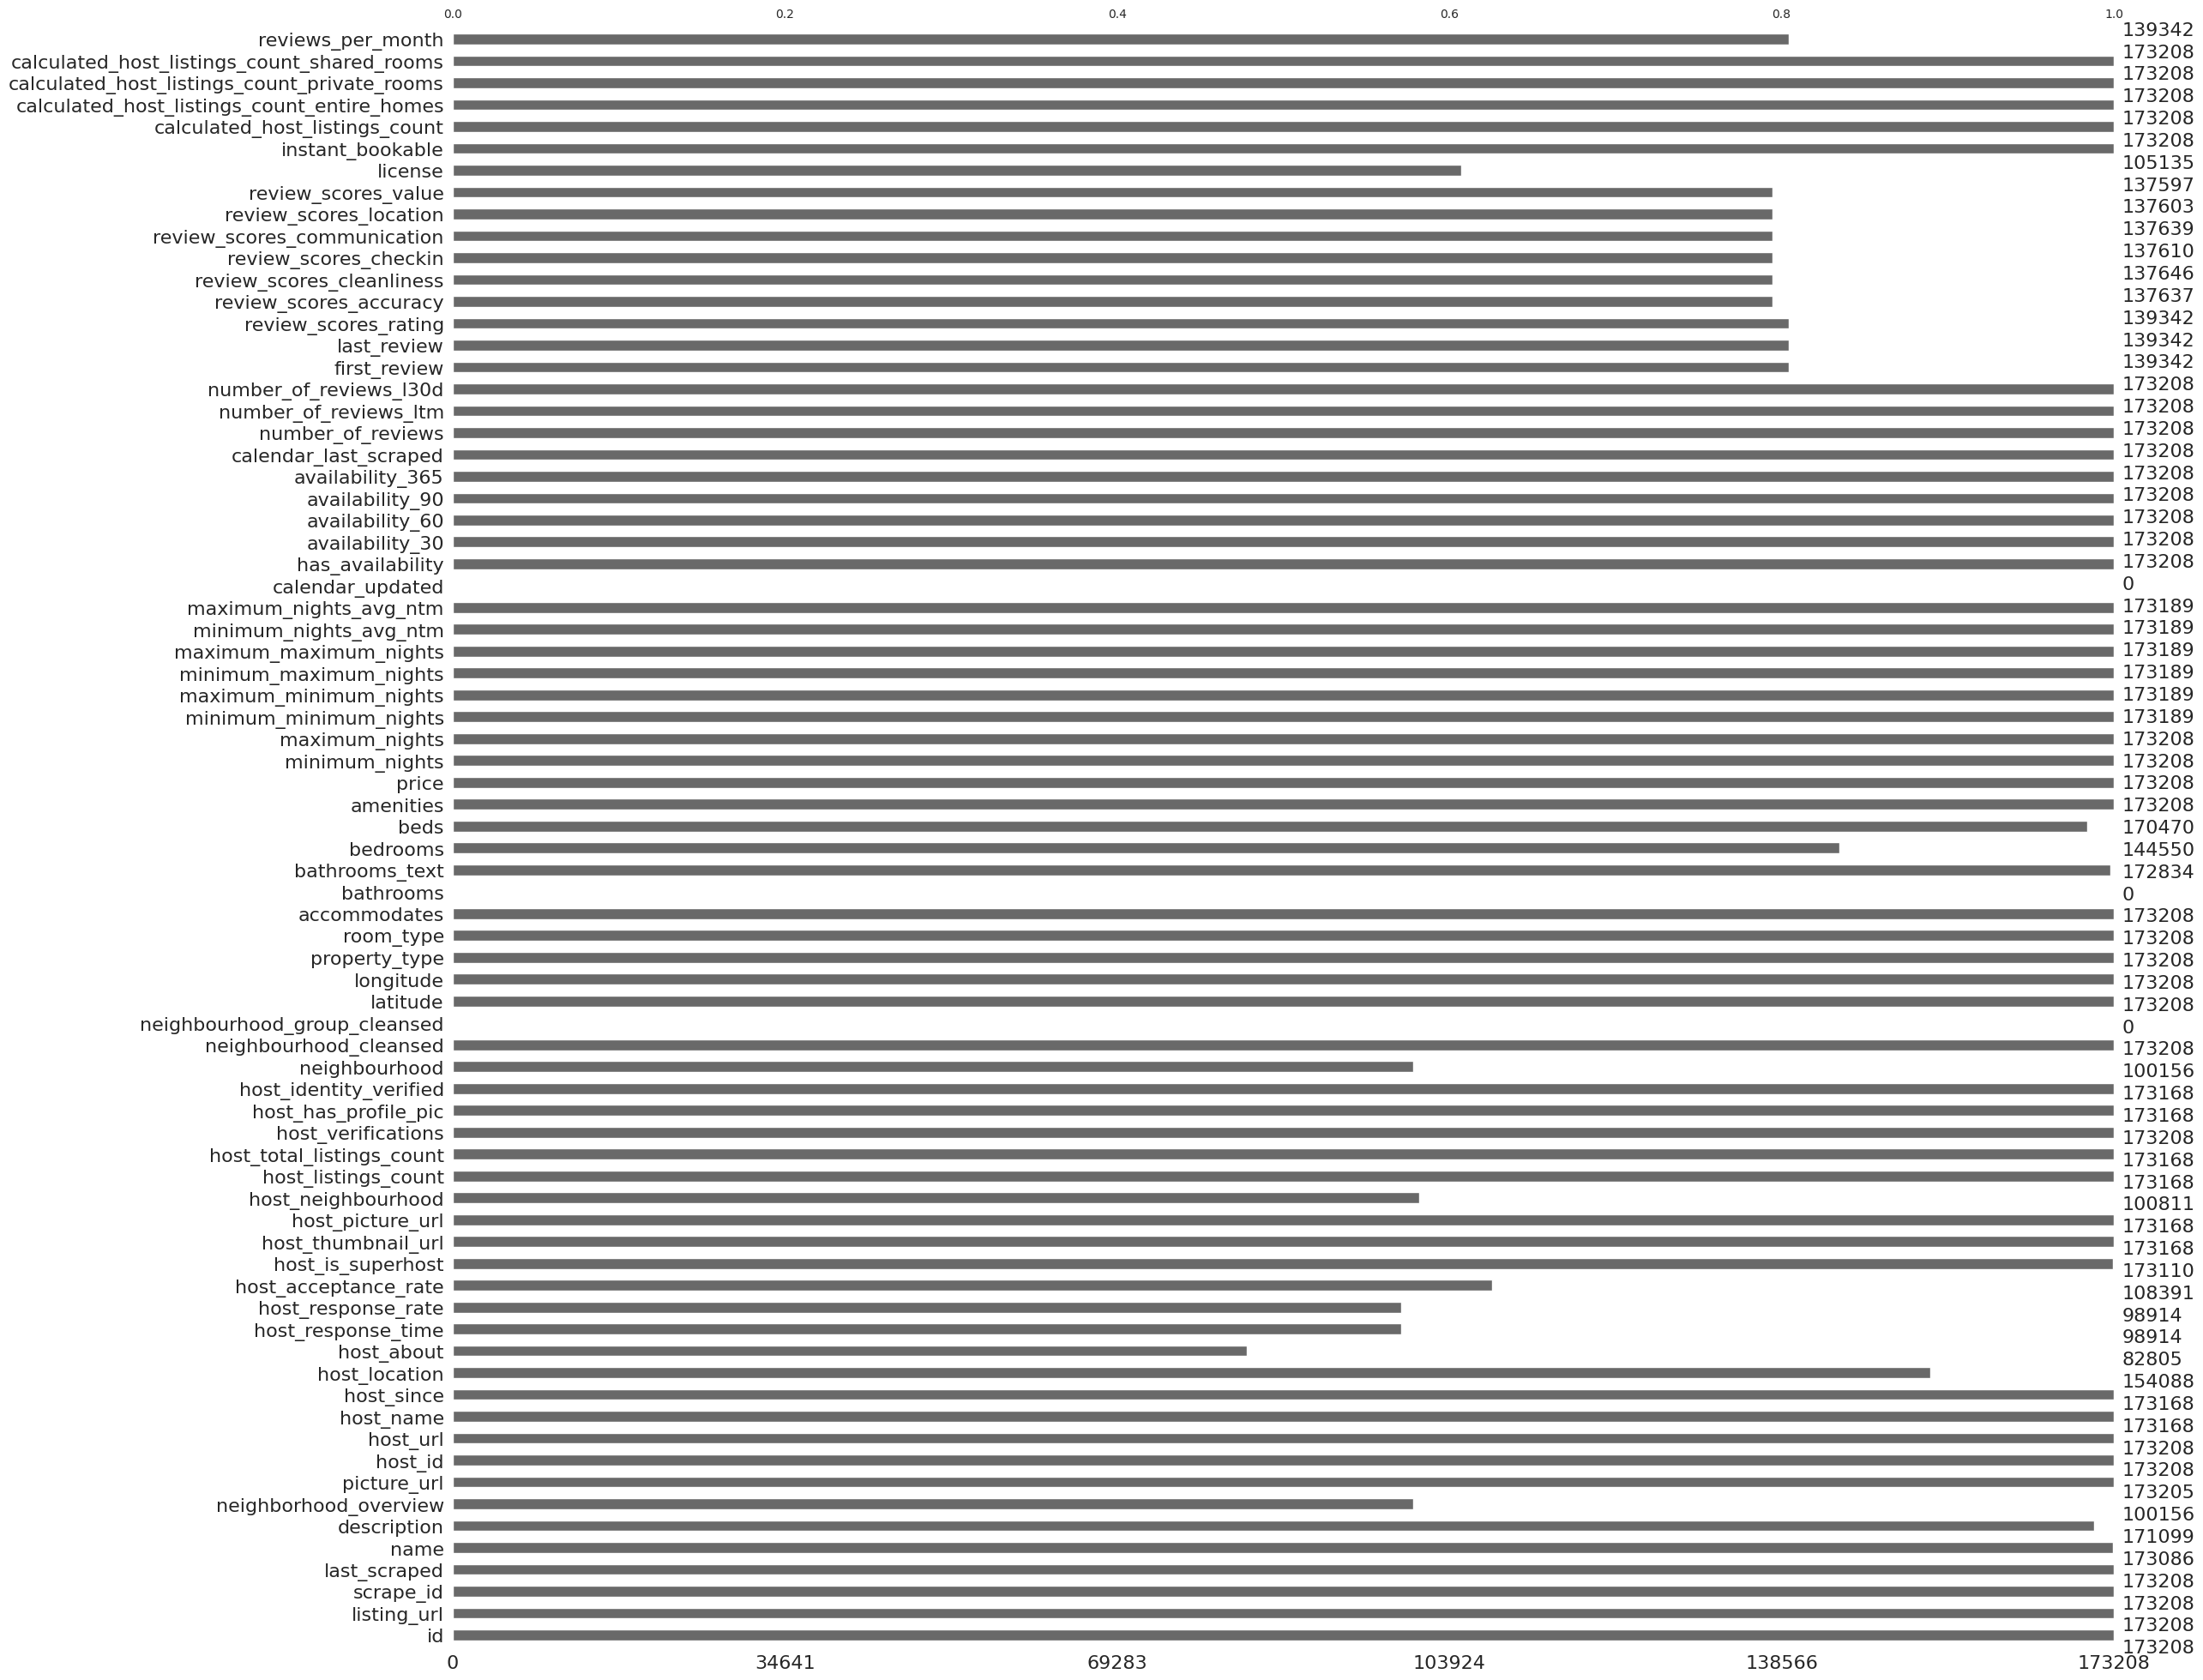

In [41]:
# Visualize the number of missing data from each feature
msno.bar(df_paris)
name = 'msno_featureschart'
plt.savefig(os.path.join(plots_dir, f'{name}.png'), bbox_inches='tight',
                    format='png')

In [42]:
# Missing features
df_paris.isnull().mean(axis=0).sort_values(ascending=False).head(10)

neighbourhood_group_cleansed    1.000000
bathrooms                       1.000000
calendar_updated                1.000000
host_about                      0.521933
host_response_rate              0.428929
host_response_time              0.428929
neighborhood_overview           0.421759
neighbourhood                   0.421759
host_neighbourhood              0.417977
license                         0.393013
dtype: float64

### 4.1.1 Drop features with insuficient information

In [43]:
# Drop features with missiing infor mation for 35% of the listings
cols_to_drop = df_paris.columns[df_paris.isnull().mean(axis=0)> 0.35]
df_paris.drop(cols_to_drop, axis=1, inplace=True)

### 4.2 Features with missing data

In [44]:
missing_features, unique_misses = data_summary(df_paris, name='col-drop-hist')

Accomodations: 173208 | Unique accomodations: 73122
Dataset features including id: 63 |     Accomodations missing features: 173208


**Add histo**
From the histogram of missing features we can observe that most of the accomondations have 12 or less missing features. We will use this number to filter the data and remove the instances with more than 12 missin features. Then we will further proceed to the data engineering and feature selection and dimessionality reduction.

In [45]:
#  Find the accommodation with more than 12 missing features
print(f'Accomodations with more than 12 missing features: {len(df_paris[missing_features > 12].index)}')

Accomodations with more than 12 missing features: 171


In [46]:
# Use the threshold to drop accomodations with more than 12 Nan columns (features)
threshold = len(df_paris.columns) - 12
df_paris.dropna(thresh=threshold, inplace=True)

### 4.3 Removing features

---
*   Remove host information from the dataset
*   Remove _minimum_maximum_nights_, _maximum_maximum_nights_, _minimum_minimum_nights_ _maximum_minimum_nights_, _minimum_nights_avg_ntm_', '_maximum_nights_avg_ntm_'
*   maximum and minimun nights will be used for the visualisation and analytics

---

- Neighbourhoods with most hosts **Buttes-Montmartre**, **Popincour**, **Passy**
- Neighbouhoods with smallest number of hosts **Louvre**, **Palais-Bourbon**, **Luxembourg** and **Élysée**.

In [47]:
# Remove columns
host_col = ['host_id', 'host_name', 'host_location', 'calendar_last_scraped', 'host_url',
            'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
            'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm']
df_paris.drop(host_col, axis=1, inplace=True)

## 5. Data Cleaning & Wrangling

### 5.1 Non-categorical features

In [48]:
from pandas.tseries.offsets import DateOffset

In [49]:
# Find the nan non-categorical features in the dataset
df_paris[df_paris.columns[df_paris.dtypes != 'object']].isna().sum(axis=0)

id                                                  0
scrape_id                                           0
last_scraped                                        0
host_since                                         16
host_listings_count                                16
host_total_listings_count                          16
latitude                                            0
longitude                                           0
accommodates                                        0
bedrooms                                        28519
beds                                             2630
minimum_nights                                      0
maximum_nights                                      0
availability_30                                     0
availability_60                                     0
availability_90                                     0
availability_365                                    0
number_of_reviews                                   0
number_of_reviews_ltm       

#### 5.1.2 Drop Features
## **Tasks**

---

Remove information cover under has_availability  maximum_ninghts and minimum_nights

**Availability**

- availability_30                                     
- availability_60                                     
- availability_90                                     
- availability_365

**Counts**

- host_listings_count                                
- host_total_listings_count
- calculated_host_listings_count                      
- calculated_host_listings_count_entire_homes         
- calculated_host_listings_count_private_rooms        
- calculated_host_listings_count_shared_rooms

**scrap_id**
- convert scrap_id to string for filtering pourpose

---



In [50]:
# Drop instances without host_since information
df_paris.drop(df_paris.host_since[df_paris.host_since.isna()].index, inplace=True)


In [51]:
# Drop availability columns
drop_avail = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
drop_columns(drop_avail, df_paris)

# Drop counts
drop_counts = ['host_listings_count', 'host_total_listings_count',
               'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
               'calculated_host_listings_count_private_rooms',
               'calculated_host_listings_count_shared_rooms']
drop_columns(drop_counts, df_paris)


In [52]:
# remap the scrape_id to string for filtration
scrape_id = {sc: f'quarter_{i+2}' for i, sc in enumerate(df_paris.scrape_id.unique())}
df_paris['scrape_id'] = df_paris['scrape_id'].map(scrape_id)

### 5.2 Filter active properties  by reviews

### **Tasks**

---

**Reviews**

- first_review is nan and hosted  6 monts before the Q2 2022 scrape date                                  
- last_review a year before the Q2 2022 scrape date                                                                       

---

In [53]:
# Get the earliest scrape date and substract 6 months
q2_scraped = (df_paris.last_scraped.nsmallest(1) - DateOffset(months=6)).values[0]
# Remove properties with no reviews and host_sice 6 months before the scrapped date Q2-2022
q2_index = df_paris[(df_paris.first_review.isna()) & (df_paris.host_since < q2_scraped)].index
drop_rows(q2_index, df_paris)

In [54]:
# Drop properties last reviewed a year before the scrapped date of Q2-2022
q2_last_review = (df_paris.last_scraped.nsmallest(1) - DateOffset(months=12)).values[0]
last_rev_index = df_paris[(df_paris.last_review < q2_last_review)].index
drop_rows(last_rev_index, df_paris)

### 5.3 Categorical features

In [55]:
df_paris[df_paris.columns[df_paris.dtypes == 'object']].isna().sum(axis=0)

listing_url                 0
scrape_id                   0
name                        2
description               451
picture_url                 0
host_is_superhost          44
host_thumbnail_url          0
host_picture_url            0
host_verifications          0
host_has_profile_pic        0
host_identity_verified      0
neighbourhood_cleansed      0
property_type               0
room_type                   0
bathrooms_text            155
amenities                   0
price                       0
has_availability            0
instant_bookable            0
dtype: int64


## **Tasks**

---
Remove name and description of the listing - for more complex task NLP can beused to process the content extract information and/or sentiment. We would utilise the amenities to extract the listing features

**Listing description**
*   name
*   description

Remove information about the host except identity_verified

**host information**

*   listing_url
*   picture_url
*   host_thumbnail_url
*   host_picture_url
*   host_verifications - cover in under identity_verified
*   host_has_profile_pic

**identity_verify**

* Drop listings withouth identity verified and last reviewed 6 months before scrapped Q2 2022

**bathrooms_text**

* Drop properties with Nan bathrooms

Reprocess columns content

**Convert text to float**

* bathrooms_text
* price

**Hot encode**

- bathrooms - extract whether is shared or not
- amenities

---



#### 5.3.1 Drop information about the host and the listing name and description

In [56]:
# Drop name and description and host information
description = ['name', 'description']
drop_columns(description, df_paris)

# Drop name and description and host information
host_info = ['listing_url', 'picture_url', 'host_thumbnail_url', 'host_picture_url',
                    'host_has_profile_pic', 'host_verifications']
drop_columns(host_info, df_paris)

# Drop listings without bathrooms
bathrooms_idx =df_paris[df_paris.bathrooms_text.isna()].index
drop_rows(bathrooms_idx, df_paris)


In [57]:
# Drop listings withouth identity verified and last reviewed 6 month before scrapped Q2 2022
identity_idx = df_paris[(df_paris.host_identity_verified =='f') &
                        (df_paris.last_review < q2_scraped)].index
drop_rows(identity_idx, df_paris)

#### 5.3.2 Convert categorical to numerical


**Bathrooms**



In [58]:
df_paris.bathrooms_text.unique()

array(['1 bath', '1 private bath', '2 baths', '1 shared bath',
       '1.5 baths', '2.5 baths', '3 shared baths', '4 baths',
       'Shared half-bath', '1.5 shared baths', '3.5 baths', '3 baths',
       '2 shared baths', 'Half-bath', '5 baths', '0 shared baths',
       '2.5 shared baths', '0 baths', '8 baths', '4.5 baths', '6 baths',
       'Private half-bath', '50 baths', '6 shared baths', '7 baths',
       '5.5 baths', '6.5 baths', '3.5 shared baths', '4 shared baths',
       '7.5 baths'], dtype=object)

In [59]:
def clean_bathroom(string):

    string = string.lower().split(' ')
    if '0' in string:
        string = 1
    elif 'half-bath' in string:
        string = 1
    else:
        string = float(string[0])

    return string

In [60]:
def encoded_bathrooms(df, col_1=None, col_2=None):
    """
    :param df: dataframe
    :param col_1: column with the text to process
    :param col_2: new clean column
    :return: None
    """
    shared_bathroom = 'shared_bathroom'
    private_bathroom = 'private_bathroom'
    df[col_2] = df[col_1].apply(clean_bathroom)

    d = {shared_bathroom: np.zeros(len(df)),
         private_bathroom: np.zeros(len(df))}

    for i, text in enumerate(df[col_1].values):

        if 'shared' in text:
            d[shared_bathroom][i] = df.iloc[i][col_2]
        else:
            d[private_bathroom][i] = df.iloc[i][col_2]

    df[shared_bathroom] = d[shared_bathroom]
    df[private_bathroom] = d[private_bathroom]

    # Drop bathrooms and bathrooms_text
    drop_columns([col_1, col_2], df)

In [61]:
encoded_bathrooms(df_paris, col_1='bathrooms_text', col_2='bathrooms' )

**Price**

In [62]:
from tqdm import tqdm

In [63]:
def price_to_float(string):
    price = string.split('$')[1].replace(',','')
    return float(price)

In [64]:
df_paris['price'] = df_paris['price'].apply(price_to_float)

### 5.4 Clean and encode amenities

#### Amenities


### Recommended Essential amenities

https://www.airbnb.co.uk/hospitality#essential-amenities

- Toilet paper
- Soap
- Linens/sheets
- At least one towel per booked guest
- At least one pillow per booked guest


Additional amenities categories include:

https://www.airbnb.co.uk/help/article/586
https://www.airbnb.co.uk/help/article/479


- Bathroom
- Bedroom and laundry
- Entertainment
- Family
- Heating and cooling
- Home Safety
- Internet and office
- Kitchen and dining
- Location features
- Outdoor
- Parking and facilities
- Services
- TV
- free parking.


In [65]:
# Find accommoodations with empty amenities "[]" and drop them from the dataset
empty_amenities = df_paris[df_paris["amenities"] == "[]"].index
print(f'Accommodations with empty amenities: {len(empty_amenities)}')
drop_rows(empty_amenities, df_paris)

Accommodations with empty amenities: 21


#### 5.4.1 Build functions to process amenities

In [66]:
# import unidecode
import pickle
from amenities import decode_unicode, common_amenities, preprocess_amenities

In [67]:
clean_amenities = []
for amenities in df_paris.amenities.values:
    decoded_amenities=decode_unicode(amenities)
    clean_amenities.append(decoded_amenities)

In [68]:
def unique_amenities(amenities_list):
    for i, l in tqdm(enumerate(amenities_list)):
        if '' in  l:
            amenities_list[i].remove('')
        amenities_list[i] = list(set(amenities_list[i]))
    return amenities_list


In [78]:
clean_amenities = preprocess_amenities(clean_amenities)
clean_amenities = unique_amenities(clean_amenities)

92728it [00:00, 270432.42it/s]


In [79]:
df_amenities = common_amenities(clean_amenities)

100%|██████████| 92728/92728 [00:00<00:00, 140965.95it/s]


In [82]:
print(f'Common amenities: {len(df_amenities)}')

Common amenities: 271


In [83]:
print("Top 10 amenities")
df_amenities.head(10)

Top 10 amenities


frequency
wifi                         88783
kitchen                      85683
essentials                   83260
heating                      83255
long term stays allowed      77452
smoke alarm                  74465
hot water                    73666
hair dryer                   73414
dishes and silverware        71057
iron                         69134

from matplotlib import pyplot as plt
_df_0['frequency'].plot(kind='hist', bins=20, title='frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['frequency'].plot(kind='line', figsize=(8, 4), title='frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

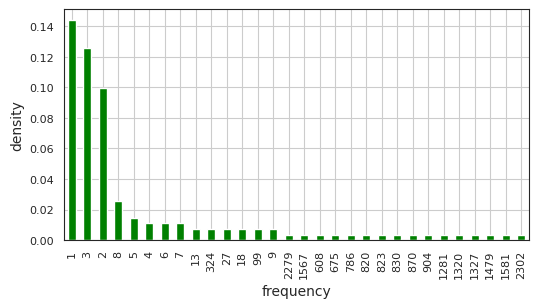

In [84]:
# Plot the density of the amenities vs frequency
(df_amenities.frequency.value_counts()[0:30]/len(df_amenities)).plot.bar(color='green',
                                                                         fontsize=8, figsize=(6,3))
plt.grid()
plt.ylabel('density')
plt.xlabel('frequency')
plt.show()


In [86]:
print(f'There are {df_amenities.value_counts()[0:3].sum()} amenities that appear in 3 \
or less listings')

There are 100 amenities that appear in 3 or less listings




---


- 25 % of the amenities have a frequency of 3 or less
- 50% of the amenities only appear in 76  or less intances


---




In [87]:
# Drop amenities with <= 3 appearance in the df_amenities
amenities_idx = df_amenities[df_amenities.frequency <= 3].index
drop_rows(amenities_idx, df_amenities)

In [88]:
for am in df_amenities.index:
    if 'years old'in am:
        drop_rows(am, df_amenities)

In [89]:
# Remove from amenities toilettries brands
toiletries = ['garnier', 'sanex', 'dove', 'dop', 'uriage', 'savon de marseille']
for item in toiletries:
    if item in df_amenities.index:
        drop_rows(item, df_amenities)

In [90]:
# Create a dataframe with encoded amenities
amenties_array = np.zeros((len(clean_amenities), len(df_amenities)))
encoded_amenities = pd.DataFrame(data=amenties_array, columns=df_amenities.index)

In [91]:
# Hot-encoding the encoded_amenities dataframe
for i in tqdm(range(len(clean_amenities))):
    for amenity in df_amenities.index:
        if amenity in clean_amenities[i]:
            encoded_amenities.at[i, amenity] = 1


100%|██████████| 92728/92728 [01:02<00:00, 1474.81it/s]


In [92]:
# Drop the amenities column from df_paris and reset index
drop_columns('amenities', df_paris)
df_paris.reset_index(drop=True, inplace=True)

In [ ]:
# Drop duplicated free weights with fitness
encoded_amenities[['free weights', 'gym or fitness equipment']][encoded_amenities['free weights']==1]
# drop_columns('free weights', encoded_amenities)


In [94]:
drop_columns('free weights', encoded_amenities)

## Add  code for coffe and stream services here

In [95]:
def regroup_amenities(df, cols_to_group=None, grouped_col=None):

    regroup = np.zeros(len(df))

    for i, v in enumerate(df[cols_to_group].values):
        if v.any() == 1:
            regroup[i] = 1

    drop_columns(col_list=cols_to_group, df=df)

    df[grouped_col] = regroup


In [96]:
# Find coffee machine or coffee makers in the dataset
coffee_cols = [col for col in encoded_amenities.columns if 'coffe'in col or 'espresso' in col]
encoded_amenities[coffee_cols].sum(axis=0)

coffee_maker         63073.0
nespresso machine     7231.0
coffee                7170.0
nespresso              478.0
espresso machine       170.0
dtype: float64

In [97]:
encoded_amenities[coffee_cols].values.shape

(92728, 5)

In [98]:
streaming_cols = ['amazon prime video', 'hbo max', 'fire tv', 'hulu', 'roku']
encoded_amenities[streaming_cols].sum(axis=0)

amazon prime video    2711.0
hbo max                112.0
fire tv                 27.0
hulu                    18.0
roku                    48.0
dtype: float64

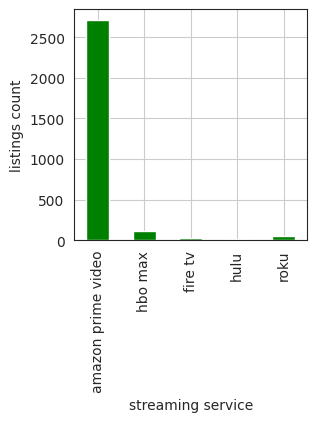

In [99]:
encoded_amenities[['amazon prime video', 'hbo max', 'fire tv', 'hulu', 'roku']].sum(axis=0).plot.bar(
    figsize=(3,3), color='green')
plt.grid()
plt.xlabel('streaming service')
plt.ylabel('listings count')
plt.show()

In [100]:
# Regroup coffee makers
regroup_amenities(encoded_amenities, cols_to_group=coffee_cols, grouped_col='coffee_maker')

# Regroup straming services
regroup_amenities(encoded_amenities, cols_to_group=streaming_cols,
                  grouped_col='stream_service')

In [101]:
encoded_amenities[['cable', 'stream_service']].value_counts()

cable  stream_service
0.0    0.0               71567
1.0    0.0               18386
0.0    1.0                1451
1.0    1.0                1324
dtype: int64

In [103]:
encoded_amenities

wifi  kitchen  essentials  heating  long term stays allowed  \
0       1.0      1.0         1.0      1.0                      0.0   
1       1.0      1.0         1.0      1.0                      1.0   
2       1.0      1.0         1.0      1.0                      1.0   
3       1.0      1.0         1.0      1.0                      1.0   
4       1.0      1.0         1.0      1.0                      1.0   
...     ...      ...         ...      ...                      ...   
92723   1.0      1.0         1.0      1.0                      1.0   
92724   1.0      1.0         1.0      1.0                      1.0   
92725   1.0      1.0         1.0      1.0                      1.0   
92726   1.0      1.0         1.0      1.0                      1.0   
92727   1.0      1.0         1.0      1.0                      1.0   

       smoke alarm  hot water  hair dryer  dishes and silverware  iron  ...  \
0              0.0        1.0         1.0                    1.0   1.0  ...   
1              1.0        0.0         1.0                    1.0   0.0  ...   
2              1.0        1.0         1.0                    1.0   1.0  ...   
3              1.0        1.0         1.0                    1.0   1.0  ...   
4              1.0        1.0         0.0                    1.0   0.0  ...   
...            ...        ...         ...                    ...   ...  ...   
92723          1.0        1.0         1.0                    1.0   1.0  ...   
92724          1.0        1.0         1.0                    1.0   1.0  ...   
92725          1.0        1.0         1.0                    1.0   1.0  ...   
92726          1.0        1.0         1.0                    0.0   1.0  ...   
92727          1.0        1.0         1.0                    0.0   1.0  ...   

       combine microwave  valley view  ironing board  resort view  bay view  \
0                    0.0          0.0            0.0          0.0       0.0   
1                    0.0          0.0            0.0          0.0       0.0   
2                    0.0          0.0            0.0          0.0       0.0   
3                    0.0          0.0            0.0          0.0       0.0   
4                    0.0          0.0            0.0          0.0       0.0   
...                  ...          ...            ...          ...       ...   
92723                0.0          0.0            0.0          0.0       0.0   
92724                0.0          0.0            0.0          0.0       0.0   
92725                0.0          0.0            0.0          0.0       0.0   
92726                0.0          0.0            0.0          0.0       0.0   
92727                0.0          0.0            0.0          0.0       0.0   

       woodburning  vineyard view  laptopfriendly workspace  coffee_maker  \
0              0.0            0.0                       0.0           1.0   
1              0.0            0.0                       0.0           1.0   
2              0.0            0.0                       0.0           1.0   
3              0.0            0.0                       0.0           0.0   
4              0.0            0.0                       0.0           1.0   
...            ...            ...                       ...           ...   
92723          0.0            0.0                       0.0           1.0   
92724          0.0            0.0                       0.0           1.0   
92725          0.0            0.0                       0.0           1.0   
92726          0.0            0.0                       0.0           1.0   
92727          0.0            0.0                       0.0           1.0   

       stream_service  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0  
...               ...  
92723             0.0  
92724             0.0  
92725             0.0  
92726             0.0  
92727             0.0  

[92728 rows x 152 columns]

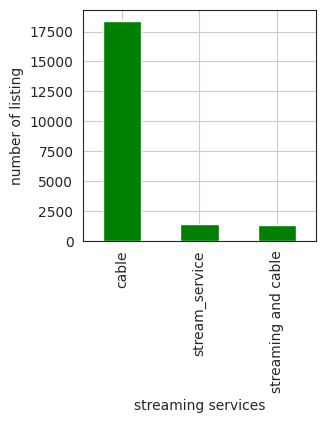

In [105]:
encoded_amenities[['stream_service', 'cable']][(encoded_amenities.stream_service==1) |
            (encoded_amenities.cable ==1)].value_counts().plot.bar(color='green', figsize=(3,3))
plt.grid()
plt.xlabel('streaming services')
plt.xticks([0, 1, 2],['cable', 'stream_service', 'streaming and cable'])
plt.ylabel('number of listing')
plt.show()

###  **5.5 Wrangling propery_type and room_type**

In [106]:
print(f'Unique types of property in airbnb: {len(df_paris.property_type.unique())}')

print('Examples of property_type include in the dataset')
df_paris.property_type.unique()[0:20]

Unique types of property in airbnb: 65
Examples of property_type include in the dataset


array(['Entire rental unit', 'Private room in condo', 'Entire condo',
       'Private room in guesthouse', 'Private room in rental unit',
       'Private room in loft', 'Entire home',
       'Private room in casa particular', 'Shared room in home',
       'Entire guesthouse', 'Room in aparthotel', 'Room in hotel',
       'Private room in townhouse', 'Entire townhouse',
       'Private room in home', 'Entire villa', 'Houseboat', 'Tiny home',
       'Private room in serviced apartment', 'Entire vacation home'],
      dtype=object)



*   **property_type** may contain information about the **room_type** i.e Room in hotel, hotel; Private room in loft
*   The propety_type will be extracted from the string



In [107]:
def clean_property(st):
    st = st.lower()
    if 'dome' in st and 'ice' in st:
        st = 'ice dome'
    elif 'farm' in st:
        st = 'farm'
    elif 'nature lodge' in st or 'entire place' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'serviced' in st or 'boutique' in st or 'rental' in st or 'casa' in st or 'suite' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'home' in st and not 'in home':
        st = st.split(' ')
        st = ' '.join(map(str, st[-2:]))
    elif 'bed and breakfast' in st:
        st = st.split(' ')
        st = ' '.join(map(str, st[-3:]))
    elif 'boat' in st:
        st = 'boat'
    else:
        st = st.split(' ')
        if st[-1] == 'room':
            st = ' '.join(map(str, st[-2:]))
        else:
            st = st[-1]
    return st

In [108]:
# Process property_type
df_paris['property_type'] = df_paris['property_type'].apply(clean_property)

In [109]:
print('Properties that offer hotel rooms and are neither hotels or boutique hotels:')
df_paris.property_type[(df_paris.room_type == 'Hotel room')  &
                       (~df_paris.property_type.isin(['hotel', 'boutique hotel']))].unique()

Properties that offer hotel rooms and are neither hotels or boutique hotels:


array(['aparthotel', 'hostel', 'bed and breakfast', 'serviced apartment'],
      dtype=object)

In [110]:
# Rename private rooms in hotel and in boutique hotel to Hotel rooms and Hotel rooms into Private
# rooms if associated with other accommodations
for i, t in df_paris[['property_type', 'room_type']].iterrows():
    if t[0] == 'aparthotel' and t[1] == 'Hotel room':
        df_paris.at[i, 'room_type'] = 'Private room'
    elif 'hotel' not in t[0] and t[1] == 'Hotel room':
        df_paris.at[i, 'room_type'] = 'Private room'
    elif t[1] == 'Private room' and (t[0] == 'hotel' or  t[0] == 'boutique hotel'):
        df_paris.at[i, 'room_type'] = 'Hotel room'

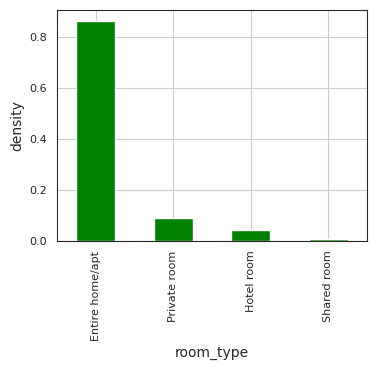

In [122]:
(df_paris.room_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8, figsize=(4, 3))
plt.grid()
plt.xlabel('room_type')
plt.ylabel('density')
plt.savefig(os.path.join(plots_dir, 'room-type.jpg'), bbox_inches='tight',
                    format='jpg')

### **5.6. Fill missing data (NaN)**



---
 **Categorical**

*  host_is_superhost

---
**Non_categorical**

*   all reviews
*   beds
*   bedrooms
---


#### **5.6.1 Fill nan - categorical**

In [123]:
df_paris[df_paris.columns[df_paris.dtypes == 'object']].isna().sum(axis=0)

scrape_id                  0
host_is_superhost         13
host_identity_verified     0
neighbourhood_cleansed     0
property_type              0
room_type                  0
has_availability           0
instant_bookable           0
dtype: int64

#### **Superhost**

In [124]:
# If superhost isna then it will be label with f (false)
df_paris.host_is_superhost.fillna(value='f', inplace=True)

#### **5.6.2 Fill nan numerical features**

In [125]:
df_paris[df_paris.columns[df_paris.dtypes != 'object']].isna().sum(axis=0)

id                                 0
last_scraped                       0
host_since                         0
latitude                           0
longitude                          0
accommodates                       0
bedrooms                       13621
beds                            1118
price                              0
minimum_nights                     0
maximum_nights                     0
number_of_reviews                  0
number_of_reviews_ltm              0
number_of_reviews_l30d             0
first_review                    3258
last_review                     3258
review_scores_rating            3258
review_scores_accuracy          3263
review_scores_cleanliness       3263
review_scores_checkin           3263
review_scores_communication     3264
review_scores_location          3263
review_scores_value             3263
reviews_per_month               3258
shared_bathroom                    0
private_bathroom                   0
dtype: int64

**Beds and bedrooms**

- Fill nan of bed  and bedrooms with by gropuping data with the same  number of beds or beddrooms and accomodates and computing the median
- If the are not similar accomodations and then follow condition minimum 1 up top  accomodates//3

In [126]:
def fill_beds_bedrooms(df, filters=None, cols_to_fill=None):
    """
    :param df: data frame
    :param filters: list of columns to filter data
    :param cols_to_fill: columns to fill nan
    :return:
    """

    if cols_to_fill is None:
        cols_to_fill = ['bedrooms', 'beds']
    assert len(filters) == 6, 'the length of filters must be 6'
    assert cols_to_fill == ['bedrooms', 'beds'], "col_to_fill must be ['bedrooms', 'beds']"

    for col in cols_to_fill:

        print('==============================', col, '==============================', sep='\n')
        feat_idx = df[df[col].isna()].index

        for idx in tqdm(feat_idx):
            col_list = df.loc[idx][filters].values

            # Find accommodation with similar features
            if col == 'beds':
                fill_idx = df[(df[filters[0]] != col_list[0]) &
                              (df[filters[1]] == col_list[1]) &
                              (df[filters[2]] == col_list[2]) &
                              (df[filters[3]] == col_list[3]) &
                              (df[filters[4]] == col_list[4]) &
                              (df[filters[5]].notna())].index.values
            else:
                fill_idx = df[(df[filters[0]] != col_list[0]) &
                              (df[filters[1]] == col_list[1]) &
                              (df[filters[2]] == col_list[2]) &
                              (df[filters[3]] == col_list[3]) &
                              (df[filters[4]].notna()) &
                              (df[filters[5]] == col_list[5])].index.values

            # Compute the median
            if fill_idx.size == 0:
                if df.at[idx, filters[3]] <= 3:
                    fill_value = 1
                else:
                    fill_value = df.at[idx, filters[3]]//2
            else:
                fill_value = df.loc[fill_idx][col].median(skipna=True)

            df.at[idx, col] = fill_value


In [127]:
filtering_features = ['id', 'property_type', 'room_type', 'accommodates',
                    'bedrooms', 'beds']
fill_beds_bedrooms(df_paris, filters=filtering_features)

bedrooms


100%|██████████| 13621/13621 [10:33<00:00, 21.49it/s]


beds


100%|██████████| 1118/1118 [00:46<00:00, 23.93it/s]


#### **5.6.3 Reviews Scores**

In [128]:
review_cols = [ k for k, v in df_paris[df_paris.columns[df_paris.dtypes ==
                                            'float64']].isna().sum(axis=0).items() if v >0]

In [130]:
# Compute Nan per feature
df_paris[review_cols].isna().sum()

review_scores_rating           3258
review_scores_accuracy         3263
review_scores_cleanliness      3263
review_scores_checkin          3263
review_scores_communication    3264
review_scores_location         3263
review_scores_value            3263
reviews_per_month              3258
dtype: int64

In [131]:
def fillna_per_col_median(df, col_to_fill=None):

    for col in col_to_fill:
        df[col].fillna(value=df[col].median(), inplace=True)

# Fill missing reviews
fillna_per_col_median(df_paris, review_cols)


In [132]:
# Replace 0 with the median
df_paris['number_of_reviews'] = [df_paris.number_of_reviews.median() if n==0 else n
                                 for n in df_paris.number_of_reviews.values]

In [133]:
# Concatenate encoded amenities with df_paris
concat_paris_df = pd.concat([df_paris, encoded_amenities], axis=1)
concat_paris_df.to_pickle('paris_clean_df.pkl')

In [134]:
del concat_paris_df
del df_paris
del encoded_amenities
gc.collect()

3053

## 6. Price visualisations and filtering



*   Compute percentile and remove the properties with price outside the range p01 > price < p99



In [135]:
df_paris = pd.read_pickle('paris_clean_df.pkl')
# from here

In [136]:
df_paris.head()

id  scrape_id last_scraped host_since host_is_superhost  \
0  26660141  quarter_2   2022-06-07 2018-07-06                 f   
1  23135649  quarter_2   2022-06-07 2018-02-06                 f   
2  23259887  quarter_2   2022-06-07 2014-08-17                 f   
3  23415468  quarter_2   2022-06-07 2015-05-04                 t   
4  26032626  quarter_2   2022-06-06 2012-08-25                 f   

  host_identity_verified neighbourhood_cleansed  latitude  longitude  \
0                      t        Buttes-Chaumont  48.88050    2.41413   
1                      f                  Passy  48.88173    2.25285   
2                      t                Reuilly  48.84699    2.43483   
3                      t        Buttes-Chaumont  48.89777    2.39917   
4                      t           Ménilmontant  48.86043    2.42996   

  property_type  ... combine microwave  valley view  ironing board  \
0   rental unit  ...               0.0          0.0            0.0   
1         condo  ...               0.0          0.0            0.0   
2   rental unit  ...               0.0          0.0            0.0   
3   rental unit  ...               0.0          0.0            0.0   
4   rental unit  ...               0.0          0.0            0.0   

   resort view  bay view  woodburning  vineyard view laptopfriendly workspace  \
0          0.0       0.0          0.0            0.0                      0.0   
1          0.0       0.0          0.0            0.0                      0.0   
2          0.0       0.0          0.0            0.0                      0.0   
3          0.0       0.0          0.0            0.0                      0.0   
4          0.0       0.0          0.0            0.0                      0.0   

   coffee_maker  stream_service  
0           1.0             0.0  
1           1.0             0.0  
2           1.0             0.0  
3           0.0             0.0  
4           1.0             0.0  

[5 rows x 186 columns]

### 6.1 Price stats

In [137]:
df_paris.price.describe()

count    92728.000000
mean       180.908519
std        460.050931
min          1.000000
25%         83.000000
50%        120.000000
75%        200.000000
max      99140.000000
Name: price, dtype: float64

In [138]:
print(f'There are {len(df_paris[df_paris.price == 1])} accommodation(s) with price $ 1.')
print(f'The type of properties are : {df_paris.property_type[df_paris.price == 1].unique()} \
and room {df_paris.room_type[df_paris.price == 1].unique()}')

There are 1 accommodation(s) with price $ 1.
The type of properties are : ['windmill'] and room ['Private room']


In [139]:
# Find the top k=3 largest prices and drop them from the dataset
print('============== The three largest prices ===========')
print(df_paris.price.nlargest(3))

============== The three largest prices ===========
81873    99140.0
86310    41681.0
78675    14407.0
Name: price, dtype: float64


In [140]:
# Drop the 3 largest prices and the smallest price from the dataframe
drop_rows(df_paris.price.nlargest(3).index, df_paris)
drop_rows(df_paris[df_paris.price == 1].index, df_paris)

- The minimum price of accomodation is $\$ 1$.  There is 1 listing with $\$ 1$ price.
- Maximum price is $\$ 99140.0$.
- 50 % of the listings have a price of $\$ 120 $ per night and a mean price $ \$ 180.91$.
- 75 % of the accommomodations have a price up to $\$ 200$ per night.
- It is highly certain that the maximum and minimum prices are outliers.

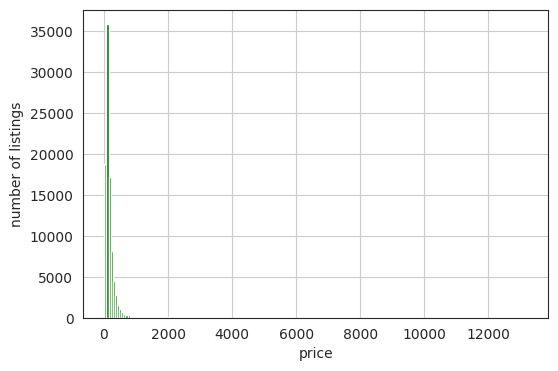

In [141]:
# Visualise price dstribution
df_paris.price.hist(bins=200, color='green', figsize=(6, 4))
plt.xlabel('price')
plt.ylabel('number of listings')
plt.show()


In [142]:
# Compute percentile for the price to eliminate potential outliers
df_paris.price.quantile([0.005, 0.01, 0.25, 0.5, 0.75, 0.80, 0.90, 0.95, 0.99, 0.995])

0.005      29.0
0.010      34.0
0.250      83.0
0.500     120.0
0.750     200.0
0.800     225.0
0.900     320.0
0.950     447.0
0.990     969.0
0.995    1500.0
Name: price, dtype: float64

- Percentile **1\%** shows a price <= \$34.0
- **Median** price \$120
- **75\%** of the listing have price <= \$200.0
- Percentile **99\%** shows a price <= \$969.86
- The price distribution is skewed to the right

#### 6.1.1 Remove price outliers with percentile


*   Preserving the accommodations within  %1 and 99% range ensure that unique luxurios accommodationes and shared accommodations are cover in the range.



In [143]:
# Find listings with price less than q01 and greater than q99
q_01 = df_paris.price.quantile(0.01)
q_99 = df_paris.price.quantile(0.99)
q_indices = df_paris[(df_paris.price < q_01) | (df_paris.price > q_99)].index
# Drop instances
drop_rows(q_indices, df_paris)

In [146]:
df_paris.price.hist(bins=50, color='green', figsize=(5, 3))
save_plot('price_freq_01_99', x='price', y='frequency')



---



#### 6.1.2 Remove any columns that maybe zero after dropping the quantile

In [147]:
# Find unique types of the features
df_paris.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('<M8[ns]'), dtype('float64')],
      dtype=object)

In [148]:
def drop_zero_sum_columns(df):
    numeric_cols = df.columns[(df.dtypes == 'float64') | (df.dtypes == 'int64')]
    for col in numeric_cols:
        if df[col].sum() == 0:
            drop_columns(col, df)

drop_zero_sum_columns(df_paris)

### 6.2  Price filter price by minimum_nights stay

In [149]:
print('Accommodation minimum_nights stats',
      '----------------------------------', sep='\n')
df_paris.minimum_nights.describe()

Accommodation minimum_nights stats
----------------------------------


count    90900.000000
mean         8.831903
std         36.826553
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max       1000.000000
Name: minimum_nights, dtype: float64

In [150]:
# Find the three longest minimum stay
df_paris.drop_duplicates(subset='minimum_nights').minimum_nights.nlargest(3)

23441    1000
17631     999
12421     500
Name: minimum_nights, dtype: int64

In [151]:
print('Accommodation maximum_nights stats',
      '----------------------------------', sep='\n')
df_paris.maximum_nights.describe()

Accommodation maximum_nights stats
----------------------------------


count    90900.000000
mean       565.107415
std        489.200618
min          1.000000
25%         31.000000
50%        365.000000
75%       1125.000000
max       1300.000000
Name: maximum_nights, dtype: float64

In [152]:
# Find the three longest maximum stay
df_paris.drop_duplicates(subset='maximum_nights').maximum_nights.nlargest(3)

2033     1300
11090    1126
3        1125
Name: maximum_nights, dtype: int64

We can observe that:
- 50 % of the listings are short-term stays up to 3 days
- 75% of the listings have a **minimum_nights** of up to 4 nights.
- The maximum in the **minimum_nights** is 1000 equivalent to 2.74 years. This is an indication of an outlier.
- Listings are markedly split into short term  $<5$ **minimum_nights** and long term starting from 30 nights.
- Airbnb is taken over the **long-term rentals**

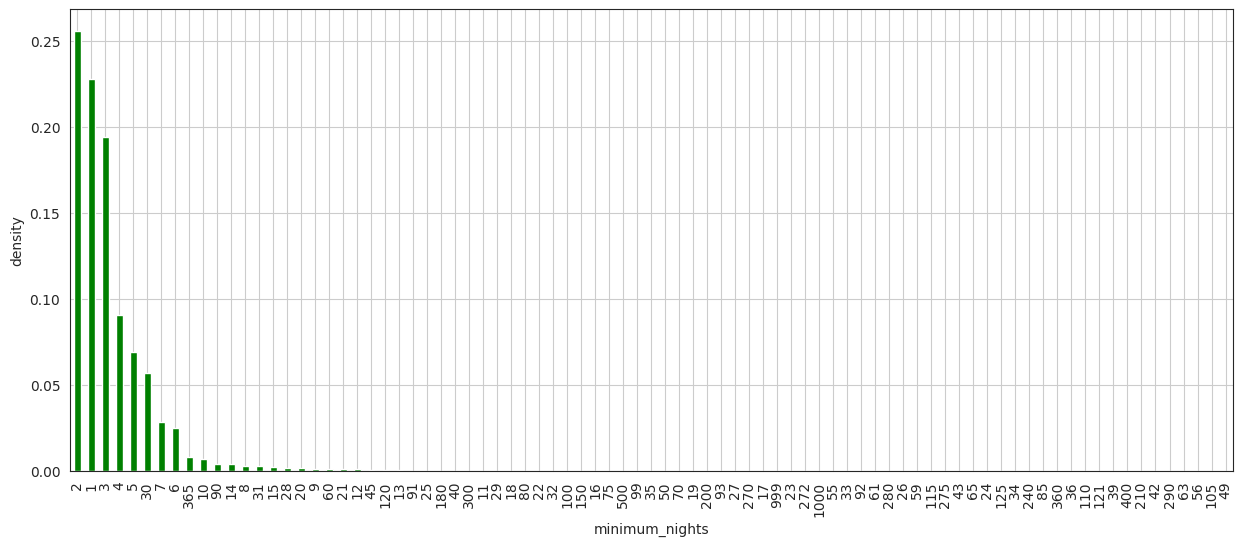

In [153]:
# Plot bar for minimum_nights counts
(df_paris.minimum_nights.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=10,
                                                                figsize=(15,6))
plt.ylabel('density')
plt.xlabel('minimum_nights')
plt.grid()

In [154]:
print(f'There are {str(len(df_paris[df_paris.minimum_nights >= 30]))} listings in airbnb \
Paris that required a minimun_nights stay of 30 nights.')
print('--------' * 12)
print(f'The maximum minimun_nights is {df_paris.minimum_nights.max()} \
    ({np.round(df_paris.minimum_nights.max()/365, 2)} years).')
unique_acc = df_paris.id[df_paris.minimum_nights >=30].unique()
unique_id = df_paris.id.unique()
print('--------' * 12)
print(f'Unique properties (id) : {len(unique_id)}')
print('--------' * 12)
print(f'Unique properties (id) with minimum_nights >= 30: {len(unique_acc)}')
print('--------' * 12)
print(f'{round(len(unique_acc)/len(unique_id)*100, 2)}% unique listings from Q2-Q4 2022 -\
required 30 minimum_nights - long term lodging')
print('--------' * 12)


There are 7232 listings in airbnb Paris that required a minimun_nights stay of 30 nights.
------------------------------------------------------------------------------------------------
The maximum minimun_nights is 1000     (2.74 years).
------------------------------------------------------------------------------------------------
Unique properties (id) : 42605
------------------------------------------------------------------------------------------------
Unique properties (id) with minimum_nights >= 30: 3723
------------------------------------------------------------------------------------------------
8.74% unique listings from Q2-Q4 2022 -required 30 minimum_nights - long term lodging
------------------------------------------------------------------------------------------------


In [155]:
# Compute the quantiles after removing the ouliers
print('Percentile computation for the minimum_nights')
df_paris.minimum_nights.quantile([0.75, 0.80, 0.90, 0.95, 0.99, 0.995, 0.999])

Percentile computation for the minimum_nights


0.750      4.0
0.800      5.0
0.900     10.0
0.950     30.0
0.990    120.0
0.995    365.0
0.999    365.0
Name: minimum_nights, dtype: float64

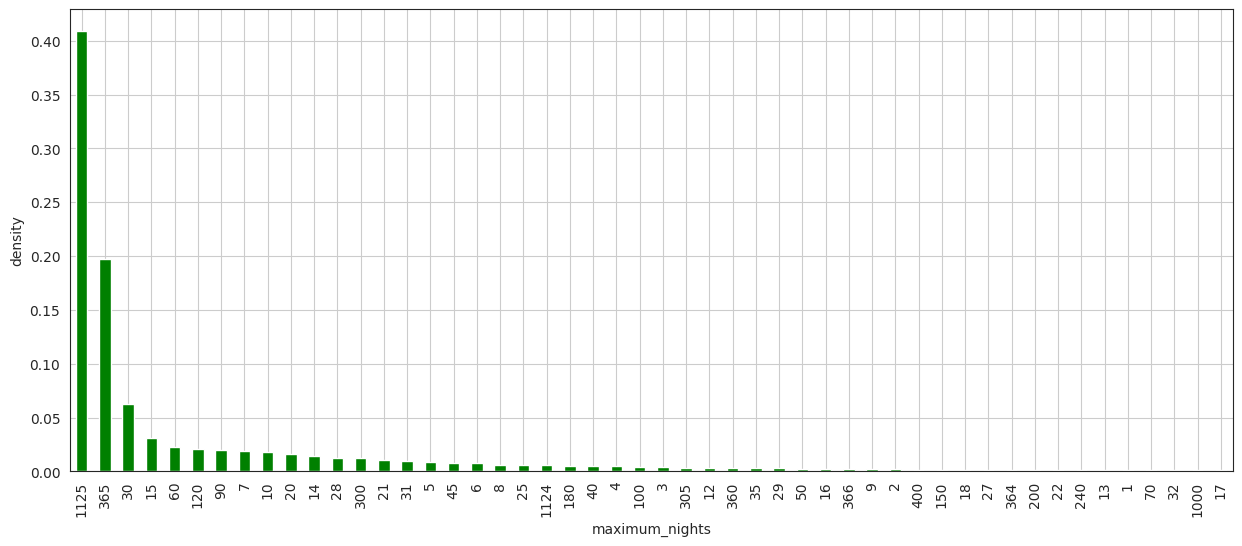

In [158]:
# Plot bar for maximum_nights counts
(df_paris.maximum_nights.value_counts()[0:50]/len(df_paris)).plot.bar(color='green', fontsize=10,
                                                                figsize=(15,6), grid=True)
plt.ylabel('density')
plt.xlabel('maximum_nights')
plt.show()


In [159]:
# Compute maximum
print('Percentile computation for the maximum_nights')
df_paris.maximum_nights.quantile([0.17, 0.20, 0.40, 0.50, 0.55, 0.60, 0.90, 0.95])

Percentile computation for the maximum_nights


0.17      28.0
0.20      30.0
0.40     365.0
0.50     365.0
0.55     365.0
0.60    1125.0
0.90    1125.0
0.95    1125.0
Name: maximum_nights, dtype: float64

* 40% of the listings in Q3-Q4 offered maximum stays of 1125
* 19% of the listing from Q3-Q4 offered maximum stay of 365 days



#### 6.2.1 Drop listing with minimum of nights over 365

In [160]:
long_term = df_paris.minimum_nights[df_paris.minimum_nights > 365].index.values
drop_rows(long_term, df_paris)
print(f' Size of dataframe after dropping of listings with minimum \
nights over 365: {len(df_paris)}')

 Size of dataframe after dropping of listings with minimum nights over 365: 90883


In [161]:
# Drop any potential zero sum coolumns after removinglisting with price over the 99 percentile
drop_zero_sum_columns(df_paris)

In [162]:
min_nights = []
for n in df_paris.minimum_nights.values:
    if  n <= 7:
        min_nights.append('short_term')
    elif  n < 30:
        min_nights.append('medium_term')
    else:
        min_nights.append('long_term')

In [163]:
# Remap to short_term minimum_nights < 30 and long_term for minimum_nights from 30.
df_paris['minimum_nights'] = min_nights

In [164]:
# Describe the the count of listings for short, medium and long stays.
df_paris.groupby(['minimum_nights'])['price'].describe().sort_values(by='mean', ascending=False)

count        mean         std   min   25%    50%    75%  \
minimum_nights                                                              
short_term      81178.0  168.278962  127.231308  34.0  89.0  129.0  200.0   
long_term        7215.0  111.499555   83.055788  34.0  61.0   88.0  131.0   
medium_term      2490.0  106.513655   76.720282  34.0  61.0   85.0  123.0   

                  max  
minimum_nights         
short_term      969.0  
long_term       946.0  
medium_term     943.0

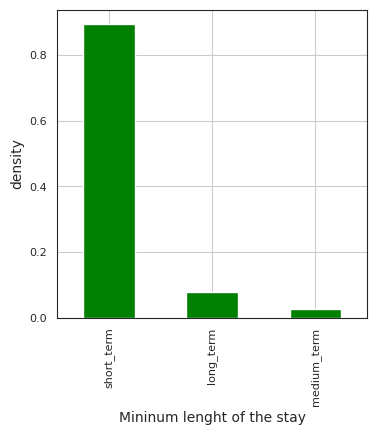

In [165]:
(df_paris.minimum_nights.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8,
                                                                figsize=(4, 4))
plt.grid()
plt.xlabel('Mininum lenght of the stay')
plt.ylabel('density')
plt.show()

In [179]:
df_paris[['price', 'minimum_nights']].boxplot(by ='minimum_nights', figsize=(4, 3))
plt.title('')
plt.xlabel('minimum_nights')
plt.ylabel('price')
save_plot('min_nighst_box', x='minimum_nights', y='price')

**8.74\%** of the listings in airbnb required long term stays starting from 30 days

### 6.3 Price filter price by scrape_id




In [168]:
df_paris.groupby(['scrape_id'])['price'].describe().sort_values(by='mean',
                                                        ascending=False)

count        mean         std   min   25%    50%    75%    max
scrape_id                                                                  
quarter_4  30244.0  166.637147  120.085958  34.0  90.0  130.0  200.0  961.0
quarter_3  33641.0  162.985851  128.531087  34.0  81.0  120.0  199.0  969.0
quarter_2  26998.0  155.843285  123.862851  34.0  80.0  116.0  189.0  969.0

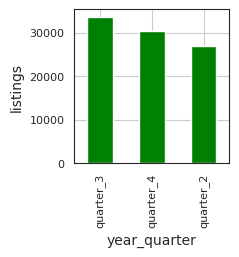

In [178]:
# Plot bar listigs per quarter
df_paris.scrape_id.value_counts().plot.bar(color='green', fontsize=8,
                                           figsize=(2, 2), xlabel='year quarter 2022',
                                           ylabel='listings')
plt.grid()
save_plot('quarters_density', x='year_quarter', y='listings', close=False)

In [176]:
df_paris[['price', 'scrape_id']].boxplot(by='scrape_id', figsize=(4, 3),
                                         xlabel=' year quarters 2022',
                                         ylabel='price')
plt.title('')
save_plot('scrape_id_box', x='scrape_id', y='price')


---
From the plot and stats we can observe that

*  There are more  more listing advertised in quarter_3 (06-Jun-22 to 09-Sep-22)
*  quarter_q2 (06-March-22 to 06-Jun-22) has the lowest mean price and the smallest number of listings.
---

### 6.4 Price stats by neighboourhood

- All accomodationes appearing in any of the Q2-Q3 2022

In [180]:
df_paris.groupby(['neighbourhood_cleansed'])['price'].describe().sort_values(by='mean',
                                                                    ascending=False)

count        mean         std   min    25%    50%  \
neighbourhood_cleansed                                                       
Louvre                  2290.0  260.123144  178.438956  45.0  135.0  206.0   
Élysée                  2662.0  257.113073  180.359715  35.0  122.0  206.0   
Palais-Bourbon          2313.0  234.754090  172.945091  34.0  115.0  184.0   
Luxembourg              2721.0  226.313962  158.491533  35.0  115.0  179.0   
Hôtel-de-Ville          3190.0  217.970755  143.344483  34.0  119.0  180.0   
Bourse                  3683.0  217.928591  146.324453  36.0  117.0  178.0   
Temple                  4427.0  216.499564  145.142634  34.0  118.0  180.0   
Opéra                   4243.0  195.292145  129.675962  36.0  105.0  160.0   
Panthéon                3025.0  189.449917  123.147818  35.0  102.0  150.0   
Passy                   6474.0  171.404476  132.123950  34.0   85.0  130.0   
Vaugirard               6358.0  159.014077  113.987133  35.0   86.0  124.0   
Entrepôt                6026.0  154.481508  110.258805  34.0   87.0  121.0   
Batignolles-Monceau     6038.0  141.545711   99.806617  34.0   80.0  110.0   
Popincourt              7137.0  141.015053   93.533375  34.0   85.0  115.0   
Observatoire            3747.0  128.607152   92.576339  34.0   73.0  101.0   
Buttes-Montmartre       8899.0  124.280048   78.147317  34.0   79.0  103.0   
Reuilly                 4732.0  116.780854   79.669861  34.0   70.0   95.0   
Gobelins                3205.0  116.757878   82.237970  34.0   70.0   98.0   
Buttes-Chaumont         4942.0  105.270192   65.273885  34.0   66.0   90.0   
Ménilmontant            4771.0  101.788933   66.750335  34.0   65.0   86.0   

                          75%    max  
neighbourhood_cleansed                
Louvre                  322.0  969.0  
Élysée                  350.0  969.0  
Palais-Bourbon          292.0  969.0  
Luxembourg              290.0  931.0  
Hôtel-de-Ville          276.0  926.0  
Bourse                  276.0  969.0  
Temple                  268.5  950.0  
Opéra                   245.0  936.0  
Panthéon                240.0  950.0  
Passy                   210.0  950.0  
Vaugirard               195.0  950.0  
Entrepôt                180.0  950.0  
Batignolles-Monceau     168.0  929.0  
Popincourt              168.0  953.0  
Observatoire            150.0  943.0  
Buttes-Montmartre       148.0  932.0  
Reuilly                 136.0  860.0  
Gobelins                136.0  968.0  
Buttes-Chaumont         124.0  936.0  
Ménilmontant            120.0  878.0

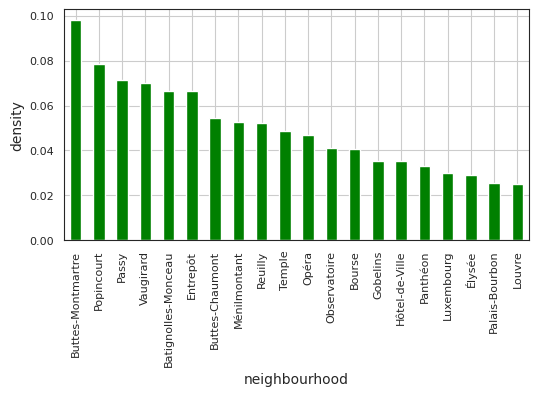

In [182]:
(df_paris.neighbourhood_cleansed.value_counts()/len(df_paris)).plot.bar(color='green',
                                                                fontsize=8, figsize=(6,3),
                                                                ylabel='listings density',
                                                                xlabel='neighboorhood')
plt.grid()
save_plot('neighbourhood', x='neighbourhood', y='density', close=False)


*   Neighbourhood with most listings **Buttes-Montmatre**

*   Cheapest neighbourhoods **Ménilmontant** \$101.79, **Gobelins** \$116.75, **Reuilly** \$116.78, **Buttes-Chaumont** \$105.27

*   Most expensive neighbourhoods  are **Élysée** \$257.11, **Louvre** \$260.11 and **Palais-Bourbon** \$234.75.

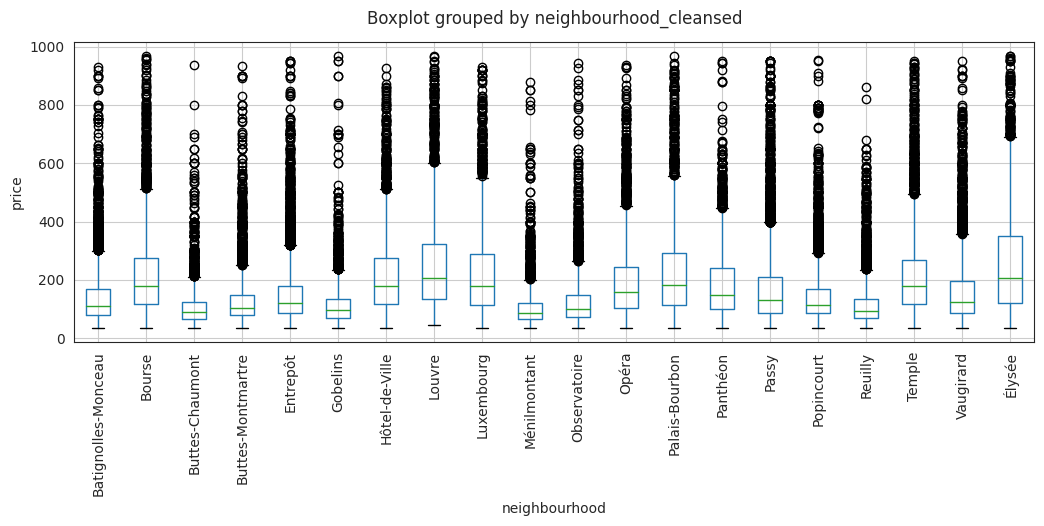

In [183]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'neighbourhood_cleansed']].boxplot(by ='neighbourhood_cleansed',
                                                      fontsize=10, rot=90, figsize=(12, 4),
                                                      xlabel='neighbouhood_cleansed',
                                                      ylabel='price')
plt.title('')
save_plot('neighbourhood_box', x='neighbourhood', y='price', close=False)

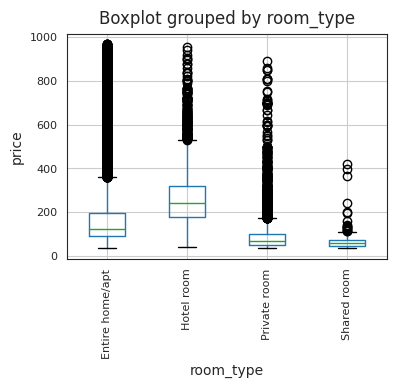

In [184]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'room_type']].boxplot(by ='room_type', fontsize=8, rot=90, figsize=(4, 3),
                                         xlabel='room type', ylabel='price')
plt.title('')
save_plot('room_type_box', x='room_type', y='price', close=False)

### 6.5 Price stats by propety_type

In [185]:
df_paris.groupby('property_type')['price'].describe().sort_values(by='mean',
                                                                  ascending=False).head()

count        mean         std    min    25%    50%  \
property_type                                                             
floor                  3.0  413.333333   11.547005  400.0  410.0  420.0   
villa                 30.0  310.866667  229.408194   34.0  142.0  255.5   
boutique hotel      2345.0  286.161991  134.976296   58.0  197.0  259.0   
serviced apartment   971.0  285.181988  183.930006   41.0  153.5  230.0   
boat                  81.0  279.962963  189.076998   40.0  120.0  245.0   

                       75%    max  
property_type                      
floor               420.00  420.0  
villa               390.75  780.0  
boutique hotel      344.00  957.0  
serviced apartment  373.00  969.0  
boat                390.00  950.0

In [186]:
(df_paris.property_type.value_counts()/len(df_paris)).plot.bar(color='green', fontsize=8,
                                                               figsize=(6,3),
                                                               xlabel='listing type',
                                                               ylabel='% total listing')
plt.grid()
save_plot('property_type', x='property_type', y='density')

<img align="center" src='figures/property_type.jpg' width=500/>

- Most common property_type **rental unit**
- Most expensive property_type **floor**, **villa**, **boutique hotel** and **serviced apartment** (mean price)
- Highest standard deviation \$ 229.41 for **villa**
- Most economical property_type **minsu**


In [189]:
# Visualise property_type
df_paris[['price', 'property_type']].boxplot(by ='property_type',
                                            fontsize=10, rot=90, figsize=(12, 4),
                                             xlabel='property_type', ylabel='price')
plt.title('')
save_plot('property_type_box', x='property_type', y='price')

### 6.6 Price vs  room_type

In [188]:
df_paris.groupby('room_type')['price'].describe().sort_values(by='mean', ascending=False)

count        mean         std   min    25%    50%    75%  \
room_type                                                                     
Hotel room        3712.0  264.388475  131.583143  41.0  178.0  240.0  319.0   
Entire home/apt  78884.0  164.988480  124.284108  34.0   89.0  125.0  198.0   
Private room      7995.0   89.395819   70.752488  34.0   52.0   70.0  100.0   
Shared room        292.0   65.606164   43.184958  34.0   44.0   57.0   71.0   

                   max  
room_type               
Hotel room       957.0  
Entire home/apt  969.0  
Private room     892.0  
Shared room      419.0

In [190]:
(df_paris.room_type.value_counts()/len(df_paris)).plot.bar(color='green',
                                                           fontsize=8, figsize=(3,2),
                                                           xlabel = 'room_type',
                                                           ylabel='density')
plt.grid()
save_plot('room_type', x='room_type', y='price')

- Most common type of room **Entire home/apt**
- Most expensive **Hotel room**
- Cheapest **Shared room**

In [191]:
# Visualise price vs neighbourhood_cleased
df_paris[['price', 'room_type']].boxplot(by ='room_type', fontsize=8, rot=90, figsize=(4, 3),
                                         xlabel='room_type',ylabel='price')
plt.title('')
save_plot('room_type_box', x='room_type', y='price')

###  6.7 Price grouped by neighboourhood,  property_type, room_type, minimum_nights and scrape_id

In [192]:
df_paris.groupby(['scrape_id', 'neighbourhood_cleansed', 'property_type',
                  'room_type', 'minimum_nights'])['price'].describe().head()

count  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term        2.0   
                                                   Private room    short_term        4.0   
                                 bed and breakfast Private room    short_term       11.0   
                                 boat              Entire home/apt short_term        1.0   
                                                   Private room    short_term        1.0   

                                                                                         mean  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights               
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      184.000000   
                                                   Private room    short_term      134.500000   
                                 bed and breakfast Private room    short_term       96.090909   
                                 boat              Entire home/apt short_term      345.000000   
                                                   Private room    short_term       40.000000   

                                                                                         std  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights              
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      55.154329   
                                                   Private room    short_term      52.373658   
                                 bed and breakfast Private room    short_term      55.818374   
                                 boat              Entire home/apt short_term            NaN   
                                                   Private room    short_term            NaN   

                                                                                     min  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      145.0   
                                                   Private room    short_term      106.0   
                                 bed and breakfast Private room    short_term       47.0   
                                 boat              Entire home/apt short_term      345.0   
                                                   Private room    short_term       40.0   

                                                                                     25%  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      164.5   
                                                   Private room    short_term      107.5   
                                 bed and breakfast Private room    short_term       64.0   
                                 boat              Entire home/apt short_term      345.0   
                                                   Private room    short_term       40.0   

                                                                                     50%  \
scrape_id neighbourhood_cleansed property_type     room_type       minimum_nights          
quarter_2 Batignolles-Monceau    aparthotel        Entire home/apt short_term      184.0   
                                                   Private room    short_term      109.5   
                                 bed and breakfast Private room    short_term       85.0   
                                 boat              Entire home/apt short_term      345.0   
                                                   Private room    short_term       40.0   

                                                                                     75%  \
scrape_id neighbourhood_cleansed property_type     room_ty

### 6.8 Drop listing with price over the 99% percentile

In [193]:
def drop_quantiles(df, col_1=None, col_2=None, col_3=None, col_4=None, col_5=None,
                   col_6=None, quant=0.99):
    feat1 = df[col_2].unique()
    feat2 = df[col_3].unique()
    feat3 = df[col_4].unique()
    feat4 = df[col_5].unique()
    feat5 = df[col_6].unique()

    for q in tqdm(feat1):
        for n in feat2:
            for p in feat3:
                for r in feat4:
                    for m in feat5:
                        q99 = df[col_1][(df[col_2] == q) & (df[col_3] == n) &
                                        (df[col_4] == p) & (df[col_5] == r) &
                                        (df[col_6] == m)].quantile(quant)
                        drop_q99 = df[(df[col_2] == q) & (df[col_3] == n) &
                                    (df[col_4] == p) & (df[col_5] == r) &
                                    (df[col_6]==m) & (df[col_1] >= q99)].index
                        if len(drop_q99) > 0:
                            df.drop(index=drop_q99, inplace=True)
    print(f'Dataset size after dropping listing with {col_1} > than quantile {quant}: {len(df)}')


In [194]:
drop_quantiles(df_paris, col_1='price', col_2='scrape_id', col_3='neighbourhood_cleansed',
               col_4='property_type', col_5='room_type', col_6='minimum_nights', quant=0.99)

100%|██████████| 3/3 [35:28<00:00, 709.51s/it]

Dataset size after dropping listing with price > than quantile 0.99: 88232


In [195]:
# Remove any columns with nan after dropping percentiles
drop_zero_sum_columns(df_paris)
df_paris.to_pickle('paris_clean_q99.pkl')

In [196]:
del df_paris
gc.collect()

101333

### 6.9 Visualisation after droppping percentile 0.99

In [197]:
df_paris = pd.read_pickle('paris_clean_q99.pkl')

In [198]:
df_paris.shape

(88232, 178)

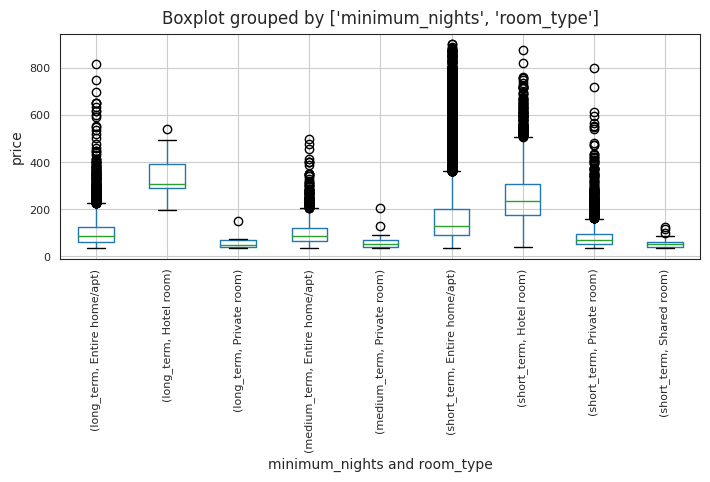

In [199]:
# Visualise price vs minimum nights
df_paris[['price', 'minimum_nights', 'room_type']].boxplot(by= ['minimum_nights', 'room_type'],
                                                    rot=90, fontsize=8, figsize=(8, 3))
plt.title('')
save_plot('minimum_nights_room_type_box', x='minimum_nights and room_type', y='price', close=False)

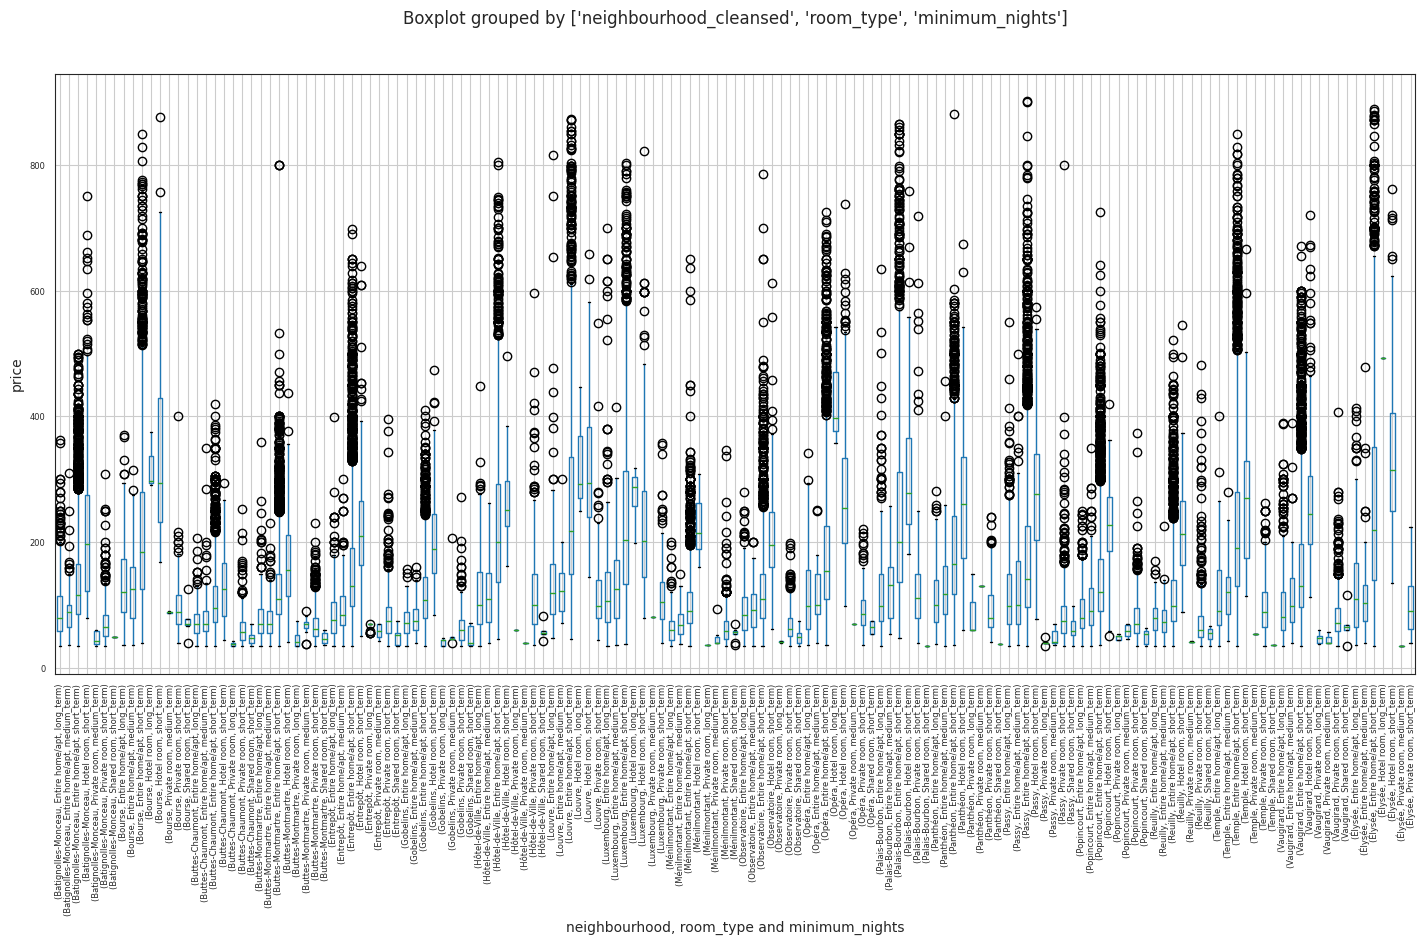

In [201]:
# Visualise price vs minimum nights
df_paris[['price', 'neighbourhood_cleansed', 'room_type',
          'minimum_nights']].boxplot(by= ['neighbourhood_cleansed', 'room_type',
                                          'minimum_nights'], rot=90, fontsize=6,
                                        figsize=(17, 8))
plt.title('')
save_plot('neigh_room_type_minimum_nights_box',
          x='neighbourhood, room_type and minimum_nights', y='price', close=False)

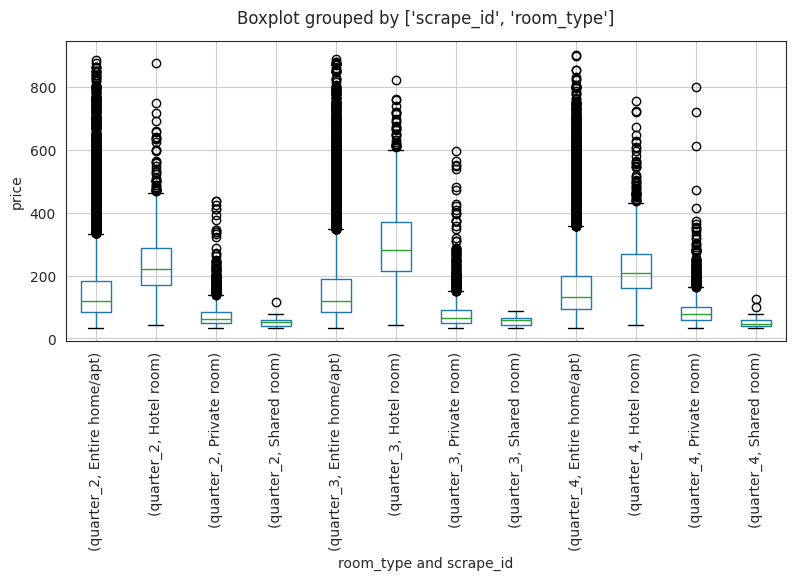

In [202]:
df_paris[['price', 'scrape_id', 'room_type']].boxplot(by= ['scrape_id',
                                            'room_type'], rot=90, fontsize=10, figsize=(9, 4))
plt.title('')
save_plot('room_type_scrape_id_box',
          x='room_type and scrape_id', y='price', close=False)

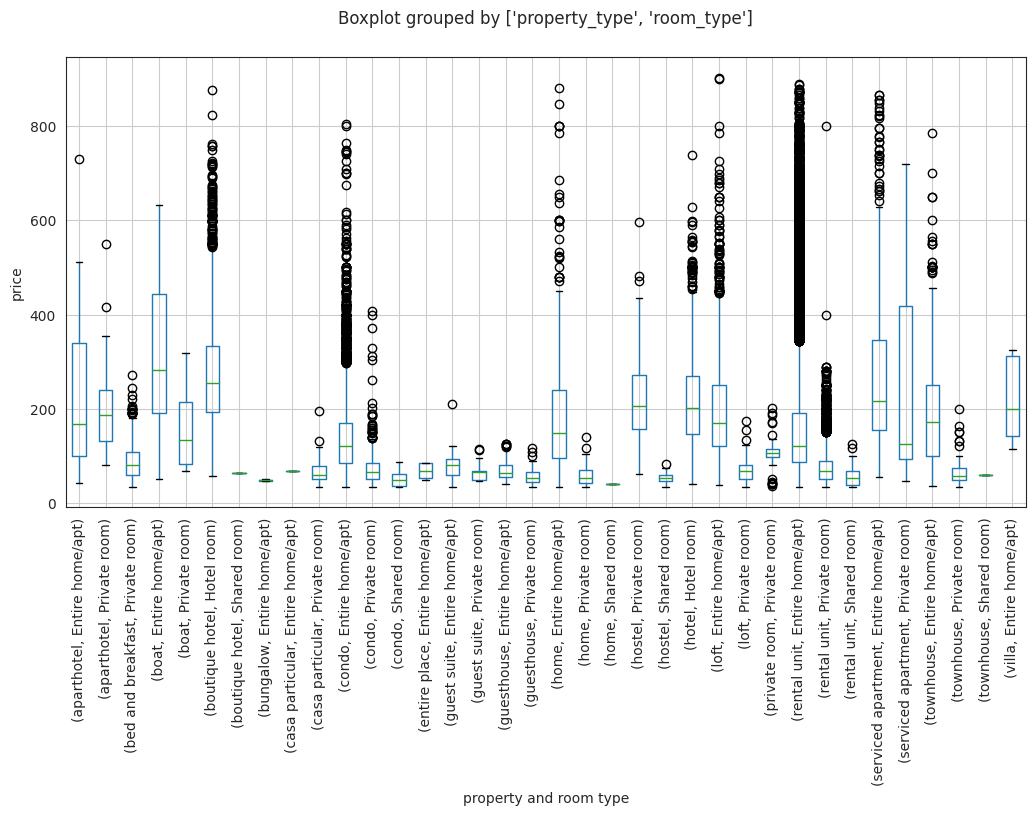

In [204]:
# %matplotlib widget
df_paris[['price', 'property_type', 'room_type']].boxplot(by =['property_type', 'room_type'],
                                                    rot=90, figsize=(12, 6))
plt.title('')
save_plot('property_room_type_box', x='property and room type', y='price', close=False)

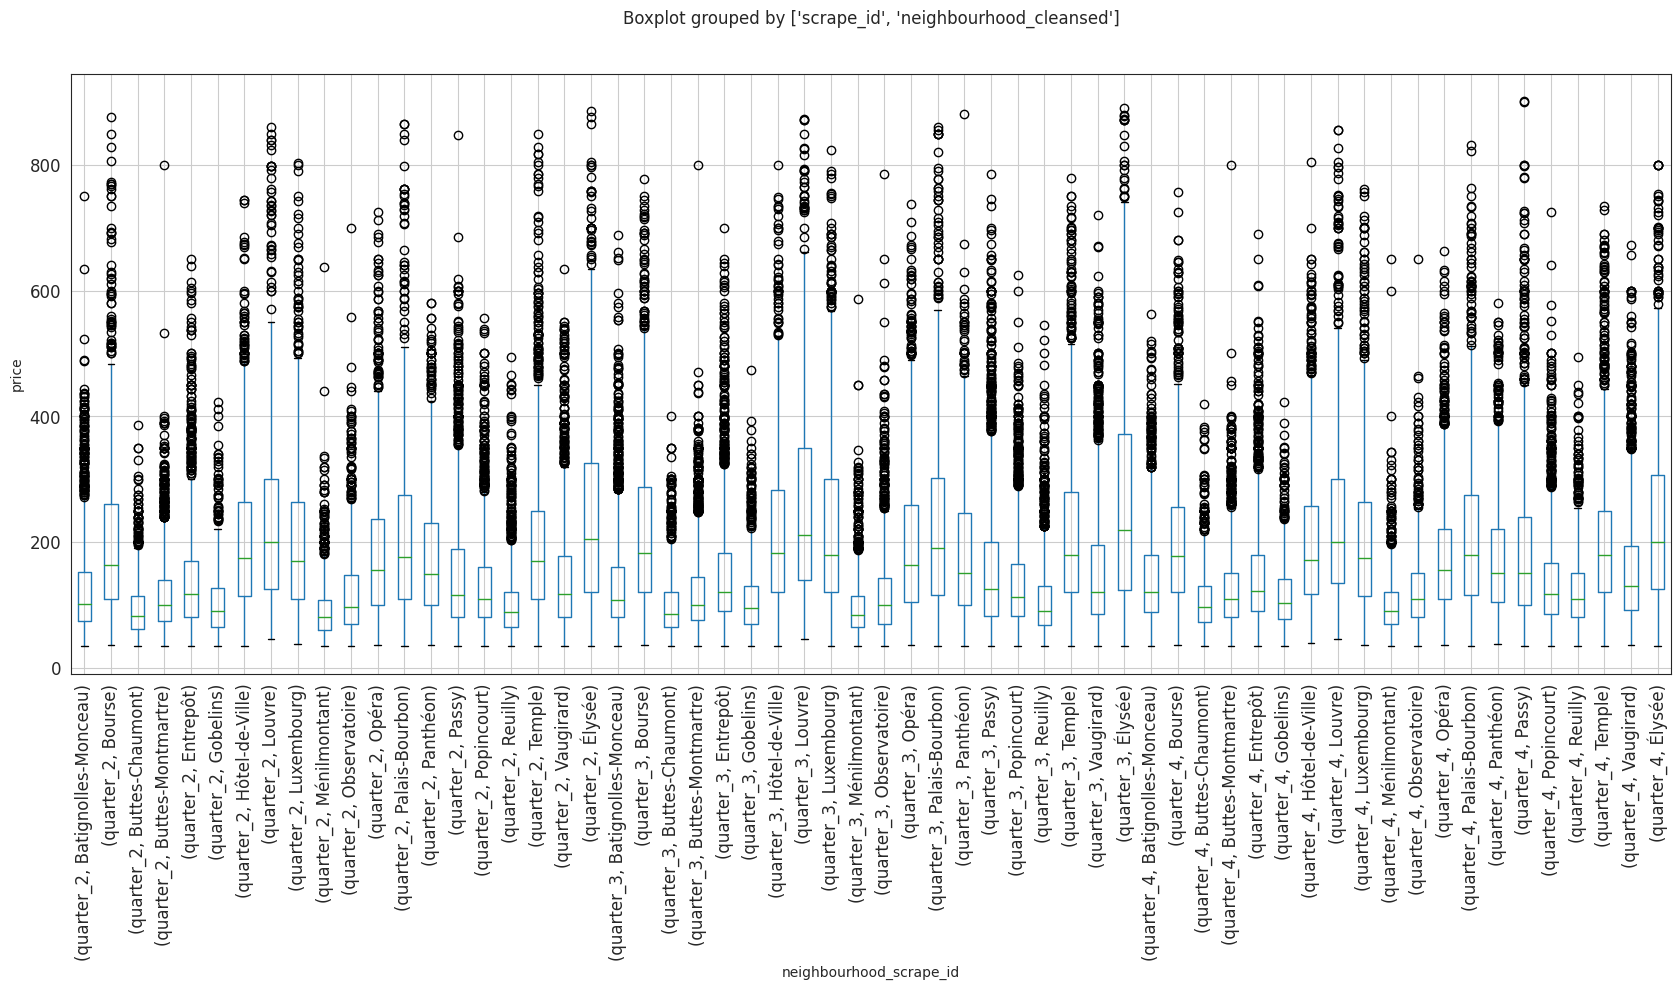

In [205]:
df_paris[['price', 'scrape_id', 'neighbourhood_cleansed']].boxplot(by= ['scrape_id',
                                'neighbourhood_cleansed'], rot=90, fontsize=12,
                                figsize=(20, 8))
plt.title('')

save_plot('neighbourhood_scrape_id_box', x='neighbourhood_scrape_id', y='price', close=False)

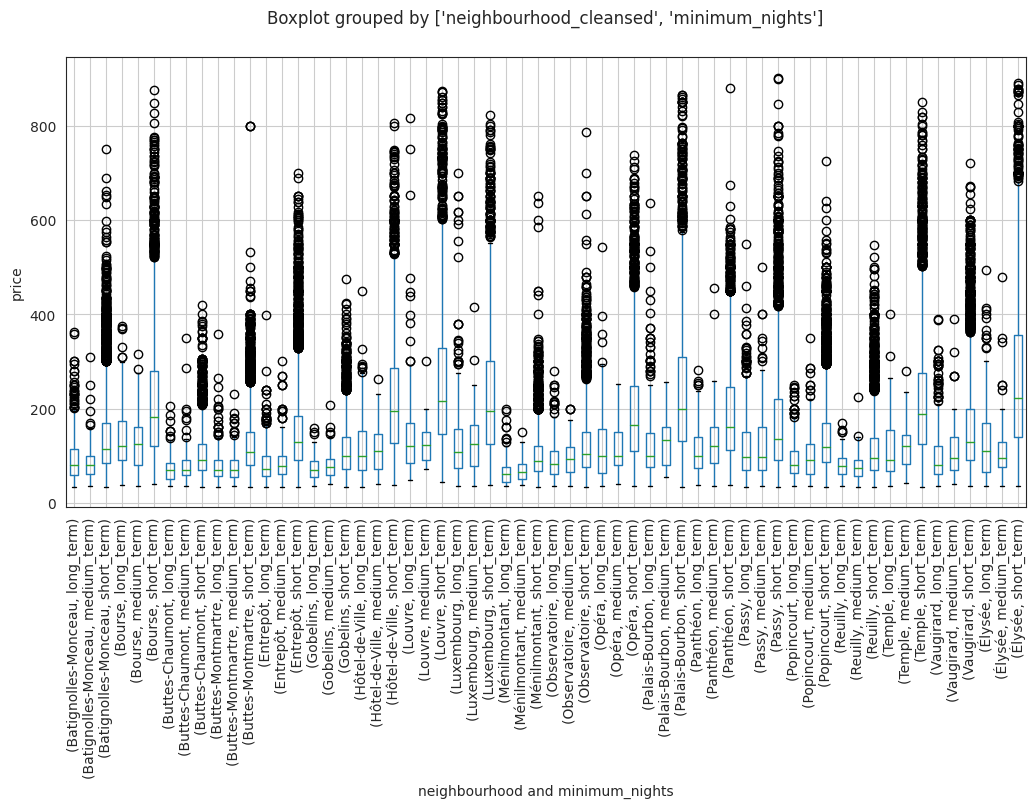

In [206]:
# %matplotlib widget
df_paris[['price', 'neighbourhood_cleansed', 'minimum_nights']].boxplot(
    by=['neighbourhood_cleansed', 'minimum_nights'], rot=90, figsize=(12, 6))
plt.title('')
save_plot('neighbourhood_minimum_nights_box', x='neighbourhood and minimum_nights', y='price', close=False)

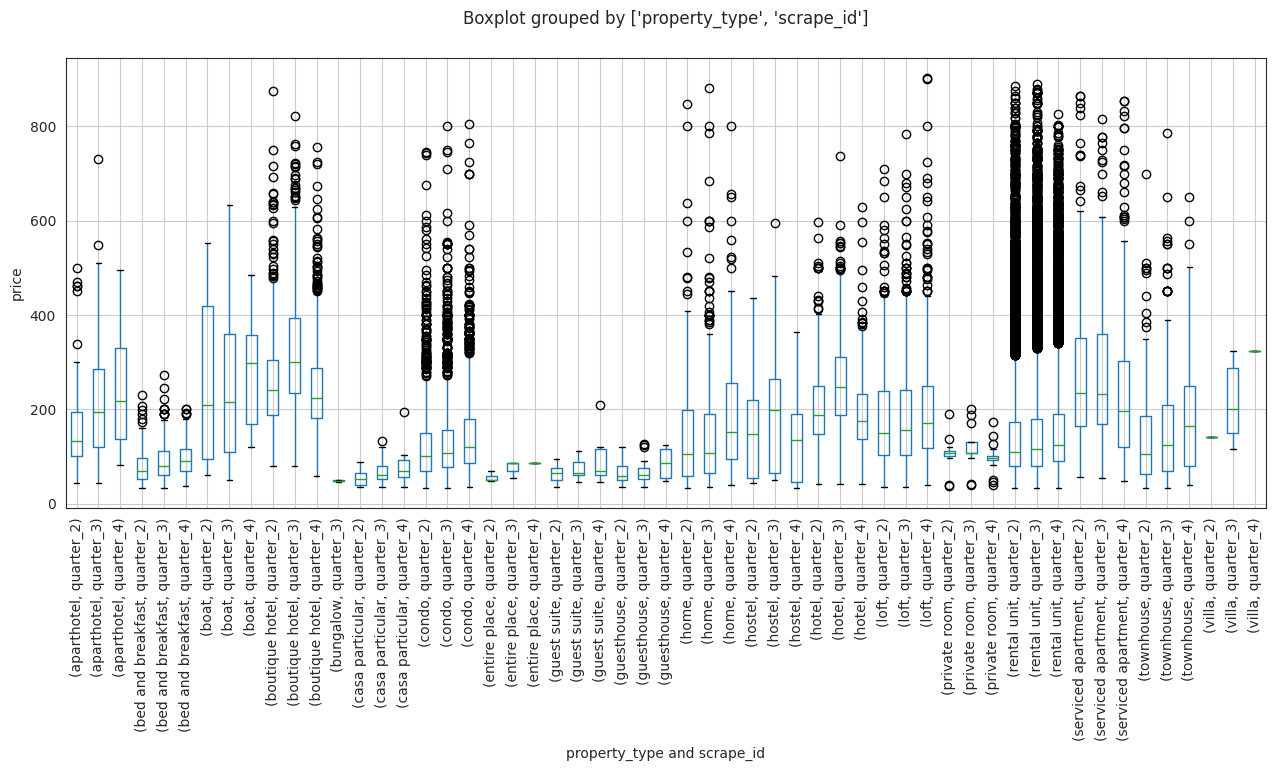

In [207]:
df_paris[['price', 'property_type', 'scrape_id']].boxplot(by=
                            ['property_type', 'scrape_id'],rot=90, figsize=(15, 6))
plt.title('')
save_plot('property_scrape_box', x='property_type and scrape_id', y='price', close=False)

In [208]:
import scipy.stats as stats

stats.f_oneway(df_paris['price'][df_paris.scrape_id == 'quarter_2'],
               df_paris['price'][df_paris.scrape_id == 'quarter_3'],
               df_paris['price'][df_paris.scrape_id == 'quarter_4'])

F_onewayResult(statistic=67.64895792439245, pvalue=4.394752678614401e-30)



---


- En general most of the properties are more expensive in quarter_3 and quarte_4.
- Neighbourhoods Élysée and Louvre have the highest mean average prices in quarter_3.
- Listings with minimum_nights of 30 or more are cheaper than short and medium term stays.


---




### Listings offering long-term accommodation

In [209]:
maximum_nights = []
for n in df_paris.maximum_nights.values:
    if  n <= 7:
        maximum_nights.append('short_term')
    elif  n < 30:
        maximum_nights.append('medium_term')
    else:
        maximum_nights.append('long_term')
df_paris['maximum_nights'] = maximum_nights

In [210]:
long_term = df_paris.scrape_id[(df_paris.minimum_nights == 'long_term')|
 (df_paris.maximum_nights == 'long_term')].value_counts()
short_term = df_paris.scrape_id[(df_paris.minimum_nights != 'long_term') &
 (df_paris.maximum_nights != 'long_term')].value_counts()

In [211]:
df_paris.scrape_id[(df_paris.minimum_nights != 'long_term') &
 (df_paris.maximum_nights != 'long_term')].value_counts()/df_paris.scrape_id.value_counts()

quarter_3    0.178940
quarter_4    0.182811
quarter_2    0.173511
Name: scrape_id, dtype: float64

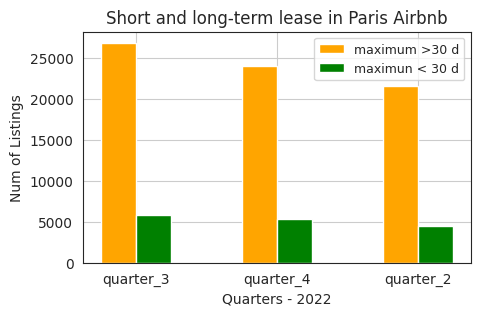

In [213]:
fig = plt.figure(figsize=(5, 3))
width=0.25
n_ticks = np.arange(len(long_term.index))

plt.bar(n_ticks, long_term.values, width = width, label='maximum >30 d', color='orange')
plt.bar(n_ticks+width, short_term.values, width=width, label='maximun < 30 d', color='green')

plt.xlabel("Quarters - 2022")
plt.ylabel("Number of Listings")
plt.title("Short and long-term lease in Paris Airbnb")
plt.xticks(n_ticks + width/2, long_term.index)
plt.legend(fontsize=9)
plt.grid()
save_plot('accom_lenght', x="Quarters - 2022", y='Num of Listings', close=False)


In [214]:
long_term/df_paris.scrape_id.value_counts()

quarter_3    0.821060
quarter_4    0.817189
quarter_2    0.826489
Name: scrape_id, dtype: float64

From the plot above it can be observed that

- Over 80\% of the listings offered in Airbnb paris from Q2-Q4 2022 offered were opened to long-term tenancy.

## 7. Feature selection

**Tasks**
- Drop unnecessary features
- Hot encode categorical features
- Scale numerical fetures
- Select features

In [215]:
# # Reset index
df_paris.reset_index(drop=True, inplace=True)

In [216]:
# Remove filtering date features
df_paris.drop(columns=df_paris.dtypes[df_paris.dtypes.values=='<M8[ns]'].keys(),
              inplace=True)

In [217]:
# Remove id, latitud and longitud columns covered by the neighbourhood,
df_paris.drop(columns='id', inplace=True)

In [218]:
stream = [1. if s >=1 else s for s in df_paris[['netflix', 'stream_service', 'apple tv']].sum(axis=1).values]

In [219]:
drop_columns(col_list=['netflix', 'stream_service', 'apple tv'], df=df_paris)

In [220]:
df_paris['stream_service'] = stream

In [221]:
# move price to the end of the columns
move_price = df_paris.pop('price')
df_paris = pd.concat([df_paris, move_price], axis=1)
df_paris.to_pickle('hot_encoded_paris.pkl')

In [222]:
del df_paris
gc.collect()

38741

### 7.1 Feature correlation

In [223]:
df_paris = pd.read_pickle('hot_encoded_paris.pkl')

In [224]:
# Features correlation with the response variable 'price'
corr_matrix = df_paris.corr(numeric_only=True).abs()
print('Feature correlation with price')
corr_matrix['price'].sort_values(ascending=False)[:10]

Feature correlation with price


price                1.000000
accommodates         0.545590
beds                 0.353948
bedrooms             0.333122
crib                 0.315632
private_bathroom     0.272091
tv                   0.246948
dishwasher           0.244298
air conditioning     0.232546
fire extinguisher    0.196126
Name: price, dtype: float64

In [225]:
corr_matrix = corr_matrix - np.diag(np.diag(corr_matrix))
pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
print('-------------------------', 'correlated pairs', '-------------------------')
pairs.head(30)

------------------------- correlated pairs -------------------------


bathroom essentials          bedroom comforts               1.000000
review_scores_value          review_scores_rating           0.845347
review_scores_accuracy       review_scores_rating           0.837190
bedrooms                     private_bathroom               0.801989
                             beds                           0.794784
review_scores_communication  review_scores_checkin          0.782026
review_scores_accuracy       review_scores_value            0.781207
review_scores_rating         review_scores_cleanliness      0.775030
                             review_scores_communication    0.771970
review_scores_communication  review_scores_accuracy         0.750646
dishes and silverware        cooking basics                 0.736571
reviews_per_month            number_of_reviews_ltm          0.730731
review_scores_rating         review_scores_checkin          0.721391
review_scores_checkin        review_scores_accuracy         0.712352
private_bathroom             beds 

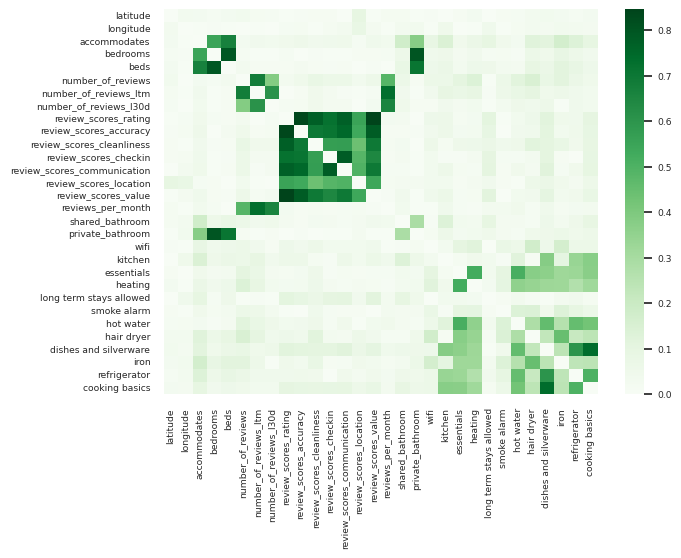

In [226]:
sns.set(font_scale=0.6, rc={'figure.figsize':(7, 5)})
sns.heatmap(corr_matrix.iloc[0:30][corr_matrix.columns[0:30]], cmap='Greens')
plt.show()


We can observe from the heat map and correlation computations that all review are highly correlated and the number of reviews. We will create:
- A new column feature with the average of all the reviews and drop the previous review columns.
- A new keep only the column last three months review, accounts for the review for each quarter.

In [227]:
scores = [c for c in df_paris.columns if 'review_scores' in c]
drop_reviews = [c for c in df_paris.columns if 'of_review' in c and 'ltm' not in c]

# create a new column with the mean of the reviews
df_paris['review_scores'] = df_paris[scores].mean(axis=1)

# drop colums
scores.extend(drop_reviews)
drop_columns(scores, df_paris)

### 7.2  Partitioning dataset and encoding categorical features

In [229]:
for c in df_paris[df_paris.columns[df_paris.dtypes == 'object']].columns:
    print(c, f'- unique categories: {len(df_paris[c].unique())}')

scrape_id - unique categories: 3
host_is_superhost - unique categories: 2
host_identity_verified - unique categories: 2
neighbourhood_cleansed - unique categories: 20
property_type - unique categories: 19
room_type - unique categories: 4
minimum_nights - unique categories: 3
maximum_nights - unique categories: 3
has_availability - unique categories: 2
instant_bookable - unique categories: 2


In [230]:
seed = 123

y = df_paris.pop('price').astype('float32')
X = df_paris

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30,
                                                  stratify=X['neighbourhood_cleansed'],
                                                  random_state=seed)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.6,
                                                random_state=seed)


In [268]:
categorical_feat = X_train.select_dtypes(include=['O']).columns
num_feat = X_train.select_dtypes(exclude=['O']).columns
print(f'Categorical features: {len(categorical_feat)}')
print('-------------' * 2)
print(f'Numerical features: {len(num_feat)}')
print('-------------' * 2)

Categorical features: 10
--------------------------
Numerical features: 152
--------------------------


### 7.3 Build feature selection pipeline

In [269]:
# Feature transformer
encode = make_column_transformer((OneHotEncoder(drop='if_binary',
                   handle_unknown='infrequent_if_exist'), categorical_feat), remainder='passthrough')
scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

#### 7.3.3 SelectPercentile with mutual_info_regression

In [270]:
# Build scaler and feature selection pipeline
pre_processing = make_pipeline(encode, scaler,
                               SelectPercentile(mutual_info_regression, percentile=50))

In [271]:
# Transform and scale train split
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
x_train_transformed = pre_processing.fit_transform(X_train, y_train_scaled.ravel())

In [272]:
x_val_transformed = pre_processing.transform(X_val)
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1))

In [273]:
score_ind = np.where(pre_processing[-1].get_support()==True)[0]
features = pre_processing.get_feature_names_out()

In [274]:
short_feat = [f.split('__')[1] for f in features]

In [275]:
dic={'feature':short_feat,
                         'score':pre_processing[-1].scores_[score_ind]}
best_feat = pd.DataFrame(dic).sort_values(by="score", ascending=False)

In [276]:
sns.set_style(style='white')

In [277]:
print(x_train_transformed.shape[1])

104


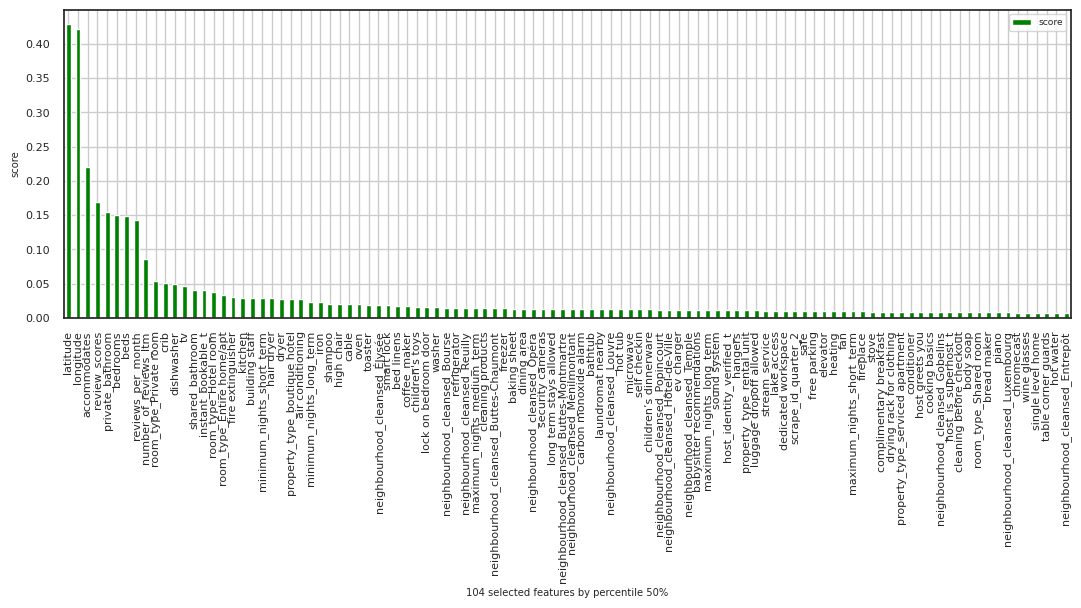

In [278]:
best_feat.plot.bar(x='feature', y='score', figsize=(13,4), fontsize=8, color='green')
plt.xlabel(f'{x_train_transformed.shape[1]} selected features by percentile 50%')
plt.ylabel('score')
plt.grid(visible=True, which='major')
plt.show()


---

 **3 most important features** - SelectPercentile with mutual_information_regression

1.   latitude
2.   longitude
3.   accommodates

---




In [279]:
# Create a dataframe of the  transformed train split
short_feat.append('price')
profile_train = np.concatenate([x_train_transformed, y_train_scaled], axis=1)
profile_df = pd.DataFrame(profile_train, columns=short_feat)

In [ ]:
# Uncomment below to create a report with the scaled and selected training features
# from ydata_profiling import ProfileReport
# ProfileReport(profile_df)

## 8. Build the training, validation and test pipeline

In [280]:
import torch.nn.functional as F
torch.manual_seed(123)
torch.cuda.manual_seed(123)

### 8.1 Build the models

#### __Build artificial neural network regressor__

In [253]:
class PriceRegressor(nn.Module):
    def __init__(self, inputs=None, hidden=None, p=0.2):

        super(PriceRegressor, self).__init__()

        assert len(hidden) == 3, 'hidden must be a list containing three sizes'

        self.input = inputs
        self.hidden = hidden
        self.dropout = nn.Dropout(p)

        self.regressor = nn.Sequential(
            nn.Linear(self.input, self.hidden[0]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(self.hidden[0], self.hidden[1]),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(self.hidden[1], self.hidden[2]),
            nn.ReLU(),
            nn.Linear(self.hidden[2], 1))

    def forward(self, x):

        x = x.type('torch.FloatTensor').to(device)

        out = self.regressor(x)

        return out.view(-1)

In [254]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [255]:
def get_models(num_features=None):
    common_params = dict(random_state=123, learning_rate=0.05, max_depth=10)
    models = dict()

    # Linear Models
    models['linear_regression'] = LinearRegression(n_jobs=8)
    models['ridge'] = Ridge(random_state=123)
    models['bayesian_ridge'] = BayesianRidge()

    # Support Vector Machines
    models['svr'] = SVR(C=10, cache_size=500)

    # Decision trees
    models['decision_tree'] = DecisionTreeRegressor(max_depth=10, random_state=123,
                                                    )
    # Ensemble methods
    models['random_forest'] = RandomForestRegressor(random_state=123, n_estimators=500,
                                                     max_depth=10, min_samples_leaf=20, n_jobs=8)
    models['gradient_boosting'] = GradientBoostingRegressor(**common_params, n_estimators=500,
                                                            min_samples_leaf=20)
    models['hist_gradient_boosting'] = HistGradientBoostingRegressor(**common_params,
                                                                     l2_regularization=0.001,
                                                                     min_samples_leaf=20)

    models['xgb'] = XGBRegressor(learning_rate=0.05, booster='gbtree', tree_method='exact',
                                 max_leaves=2, max_depth=10, n_estimators=500,
                                 alpha=0.001, random_state=123, device='cpu', verbosity=0)

    models['LGBM'] = LGBMRegressor(**common_params, n_estimators=500, alpha=0.001,
                                   num_leaves=30, force_row_wise=True)

    # Shallow neural network
    models['ann_regressor'] = NeuralNetRegressor(module=PriceRegressor,
                                                 module__inputs=num_features,
                                                 module__hidden=[512, 512, 256],
                                                 module__p=0.3,
                                                 train_split=None,
                                                 max_epochs=120,
                                                 optimizer=torch.optim.AdamW,
                                                 lr=0.001,
                                                 device=device,
                                                 iterator_train__shuffle=True,
                                                 verbose=0)

    return models

#### 8.5 Helper function, training and evaluation functions

In [256]:
def evaluation(x, y, model, full_pipeline=False):

    if full_pipeline:
        y_pred = model.predict(x)

    else:
        y = target_scaler.inverse_transform(y.reshape(-1, 1))
        y_pred = model.predict(x)
        y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1))

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mean_squared_error(y, y_pred, squared=False)

    return r2, mae, mape, mse, rmse, y_pred

In [257]:
def train_models(train, val, model_dir=None, save=True):

    metrics = defaultdict(dict)
    predictions = {}
    x_train, y_train = train[0], train[1]
    x_val, y_val = val[0], val[1]

    models = get_models(x_train.shape[1])

    for k, v in tqdm(models.items()):
        print('')
        print(f'Building {k} pipeline')

        model = v.fit(x_train, y_train.ravel())
        r2 = round(model.score(x_train, y_train), 4)

        # Validation
        v_r2, v_mae, v_mape, v_mse, v_rmse, v_pred = evaluation(x_val, y_val, model)

        print('r2 training score: {0:.4f} | validation score: {1:.4f} '.format(
                                                                    r2, v_r2))
        if save:
            filename = os.path.join(model_dir, f'{k}.jbl')
            joblib.dump(model, filename)

        metrics[k] = {'train_r2': r2, 'val_r2': v_r2, 'mean_yhat_val': v_pred.mean(),
                      'val_mae': v_mae, 'val_mape': v_mape, 'val_mse': v_mse, 'val_rmse': v_rmse}

        predictions[k] = v_pred

    return metrics, predictions

## 9. Train, validation, test and evaluation of the models performance

### 9.1 Train, validation, test and evaluation

In [258]:
models_dir = os.path.join(os.getcwd(), 'weights')
try:
    os.makedirs(models_dir, exist_ok=False)
except FileExistsError:
    pass

In [ ]:
all_metrics, val_predictions = train_models((x_train_transformed, y_train_scaled),
                                (x_val_transformed, y_val_scaled),
                                  models_dir)

  9%|████▎                                          | 1/11 [00:00<00:01,  9.93it/s]


Building linear_regression pipeline
r2 training score: 0.5512 | validation score: 0.5513 

Building ridge pipeline
r2 training score: 0.5509 | validation score: 0.5518 

Building bayesian_ridge pipeline


 27%|████████████▊                                  | 3/11 [00:00<00:02,  2.96it/s]

r2 training score: 0.5512 | validation score: 0.5516 

Building svr pipeline


 36%|█████████████████                              | 4/11 [00:46<01:52, 16.13s/it]

r2 training score: 0.7590 | validation score: 0.6383 

Building decision_tree pipeline


 45%|█████████████████████▎                         | 5/11 [00:47<01:06, 11.04s/it]

r2 training score: 0.6381 | validation score: 0.5944 

Building random_forest pipeline
r2 training score: 0.6606 | validation score: 0.6394 


 55%|█████████████████████████▋                     | 6/11 [01:14<01:19, 15.98s/it]


Building gradient_boosting pipeline


 64%|█████████████████████████████▉                 | 7/11 [05:45<06:24, 96.21s/it]

r2 training score: 0.9044 | validation score: 0.7936 

Building hist_gradient_boosting pipeline


 73%|██████████████████████████████████▏            | 8/11 [05:47<03:20, 66.94s/it]

r2 training score: 0.7008 | validation score: 0.6877 

Building xgb pipeline


 82%|██████████████████████████████████████▍        | 9/11 [07:08<02:22, 71.30s/it]

r2 training score: 0.9459 | validation score: 0.8039 

Building LGBM pipeline
[LightGBM] [Info] Total Bins 1426
[LightGBM] [Info] Number of data points in the train set: 61762, number of used features: 104
[LightGBM] [Info] Start training from score 0.140500


 91%|█████████████████████████████████████████▊    | 10/11 [07:10<00:50, 50.33s/it]

r2 training score: 0.7886 | validation score: 0.7420 

Building ann_regressor pipeline
r2 training score: 0.9014 | validation score: 0.7609 


100%|██████████████████████████████████████████████| 11/11 [14:46<00:00, 80.55s/it]


In [ ]:
metrics_robust_scaler = pd.DataFrame.from_dict(all_metrics).round(4)
metrics_robust_scaler.to_csv('metrics_robust_scaled.csv')
metrics_robust_scaler.to_markdown('metrics_robust.md')

In [ ]:
metrics_robust_scaler = pd.read_csv('metrics_robust_scaled.csv', index_col=[0])

In [ ]:
metrics_robust_scaler

linear_regression      ridge  bayesian_ridge        svr  \
train_r2                  0.5512     0.5509          0.5512     0.7590   
val_r2                    0.5513     0.5518          0.5516     0.6383   
mean_yhat_val           155.4762   155.4898        155.4817   166.9753   
val_mae                  50.3986    50.4400         50.4109    50.4770   
val_mape                  0.3819     0.3820          0.3819     0.4307   
val_mse                5426.5715  5420.4795       5422.5558  4374.1229   
val_rmse                 73.6653    73.6239         73.6380    66.1372   

               decision_tree  random_forest  gradient_boosting  \
train_r2              0.6381         0.6606             0.9044   
val_r2                0.5944         0.6394             0.7936   
mean_yhat_val       155.0423       155.0555           155.2303   
val_mae              47.0199        44.5361            33.0069   
val_mape              0.3437         0.3301             0.2412   
val_mse            4905.6751      4360.7846          2495.4936   
val_rmse             70.0405        66.0362            49.9549   

               hist_gradient_boosting        xgb       LGBM  ann_regressor  
train_r2                       0.7008     0.9459     0.7886         0.9014  
val_r2                         0.6877     0.8039     0.7420         0.7609  
mean_yhat_val                155.3484   155.3208   155.1306       152.9984  
val_mae                       41.4407    31.6224    37.6685        35.6999  
val_mape                       0.3072     0.2308     0.2757         0.2795  
val_mse                     3777.3285  2371.0896  3119.5080      2891.4407  
val_rmse                      61.4600    48.6938    55.8526        53.7721

In [259]:
import scipy.stats as ss

In [ ]:
# Find statistical comparison among the three top models
H, p_value = ss.kruskal(val_predictions['xgb'], val_predictions['ann_regressor'],
                            val_predictions['gradient_boosting'])
f'Reject the null hypothesis p-value: {p_value[0]:.4f}' if p_value <= 0.05 else f'Fail to reject the null hypothesis p-value: {p_value[0]:.4f}'

'Reject the null hypothesis p-value: 0.0010'

In [ ]:
stat, p =  ss.ks_2samp(val_predictions['xgb'].reshape(-1), val_predictions['ann_regressor'].reshape(-1), alternative='two-sided', method='auto')
print('Statistical Comparison vs and ann_regressor: Two-sample Kolmogorov–Smirnov test')
f'Reject the null hypothesis: {p:.4f}' if p <= 0.05 else f'Fail to reject the null hypothesis p-value: {p:.4f}'

Statistical Comparison vs and ann_regressor: Two-sample Kolmogorov–Smirnov test


'Reject the null hypothesis: 0.0000'

In [ ]:
stat_2, p2 =ss.ks_2samp(val_predictions['xgb'].reshape(-1), val_predictions['gradient_boosting'].reshape(-1), alternative='two-sided', method='auto')
print('Statistical Comparison xgb vs gradient_boosting: Two-sample Kolmogorov–Smirnov test')
f'Reject the null hypothesis  {p2:.4f}' if p2 <= 0.05 else f'Fail to reject the null hypothesis p-value: {p2:.4f}'

Statistical Comparison xgb vs gradient_boosting: Two-sample Kolmogorov–Smirnov test


'Fail to reject the null hypothesis p-value: 0.9915'

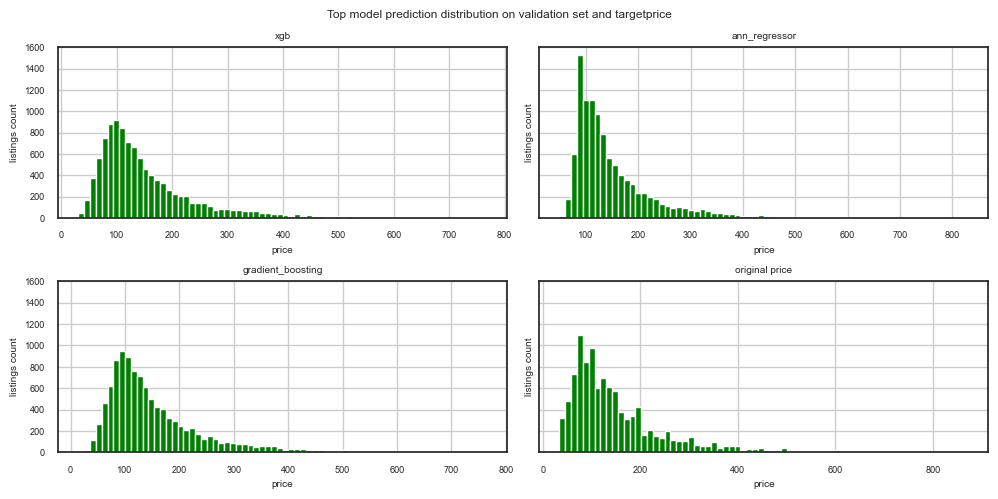

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)
fig.suptitle('Top model prediction distribution on validation set and targetprice')
axs[0, 0].hist(val_predictions['xgb'], bins=70, color='Green')
axs[0, 0].set_title('xgb')
axs[0, 1].hist(val_predictions['ann_regressor'], bins=70, color='Green')
axs[0, 1].set_title('ann_regressor')
axs[1, 0].hist(val_predictions['gradient_boosting'], bins=70, color='Green')
axs[1, 0].set_title('gradient_boosting')
axs[1, 1].hist(y_val.values, bins=70 , color='Green')
axs[1, 1].set_title('original price')

for ax in axs.flat:
    ax.set(xlabel='price', ylabel='listings count')
    ax.grid()
plt.tight_layout()
plt.show()

### 9.2 Ranking Models

In [ ]:
models_rank = metrics_robust_scaler.copy().T

for col in models_rank:
    if 'mean' in col:
        pass
    else:
        if 'r2' in col:
            models_rank[f'rank_{col}'] = models_rank[col].rank(ascending=False)

        else: models_rank[f'rank_{col}'] = models_rank[col].rank()
        drop_columns(col, models_rank)
models_rank.to_markdown('models_ranks_robust.md')

In [ ]:
models_rank

mean_yhat_val  rank_train_r2  rank_val_r2  \
linear_regression            155.4762            9.5         11.0   
ridge                        155.4898           11.0          9.0   
bayesian_ridge               155.4817            9.5         10.0   
svr                          166.9753            5.0          7.0   
decision_tree                155.0423            8.0          8.0   
random_forest                155.0555            7.0          6.0   
gradient_boosting            155.2303            2.0          2.0   
hist_gradient_boosting       155.3484            6.0          5.0   
xgb                          155.3208            1.0          1.0   
LGBM                         155.1306            4.0          4.0   
ann_regressor                152.9984            3.0          3.0   

                        rank_val_mae  rank_val_mape  rank_val_mse  \
linear_regression                8.0            8.5          11.0   
ridge                           10.0           10.0           9.0   
bayesian_ridge                   9.0            8.5          10.0   
svr                             11.0           11.0           7.0   
decision_tree                    7.0            7.0           8.0   
random_forest                    6.0            6.0           6.0   
gradient_boosting                2.0            2.0           2.0   
hist_gradient_boosting           5.0            5.0           5.0   
xgb                              1.0            1.0           1.0   
LGBM                             4.0            3.0           4.0   
ann_regressor                    3.0            4.0           3.0   

                        rank_val_rmse  
linear_regression                11.0  
ridge                             9.0  
bayesian_ridge                   10.0  
svr                               7.0  
decision_tree                     8.0  
random_forest                     6.0  
gradient_boosting                 2.0  
hist_gradient_boosting            5.0  
xgb                               1.0  
LGBM                              4.0  
ann_regressor                     3.0

---

Statistical Summary

---

From the statistical testing, we can conclude  that:

- Gradient Boosting and XGBoost models predict price with no statistical significance with 95\% confidence
- The performance of XGBoost is statistically different from the shallow artificial neural network with 95\% confidence
- The model with the highest rank in all metrics is XGBoost, and trains faster than Gradient Boosting. Therefore, this model will be optimised.

## 10. Hyper parameter tuning for the best ranked model

### 10.1 Gridsearch for XGBoost

In [ ]:
# Concatenate train and val splits
X_grid = pd.concat([X_train, X_val])
y_grid = pd.concat([y_train, y_val])

In [ ]:
best_model = [model for model in models_rank.rank_val_rmse.nsmallest(n=1).keys()][0]
print(f'Best model: {best_model.upper()}')
essemble_model = {k: v for (k, v) in get_models(X_train.shape[1]).items() if k == best_model}

Best model: XGB


In [ ]:
xgb_processing = make_pipeline(encode)

In [ ]:
# Run set verbosity to one to silence warning
essemble_model['xgb'].set_params(verbosity=1)

XGBRegressor(alpha=0.001, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=2,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
# !python -m pip install skops

In [262]:
def grid_search(model=None, preprocessing=None, x=None, y=None, model_dir=models_dir):

    assert type(model) == dict, 'models must be a dictionary'


    for k, v in tqdm(model.items()):

        print(f'Optimizing {k}')

        pipeline = make_pipeline(preprocessing, v)

        model = TransformedTargetRegressor(regressor=pipeline,
                                            transformer=target_scaler)

        name = list(pipeline.get_params().keys())[4]

        params_grid = {f'regressor__{name}__max_depth': [8, 10],
            f'regressor__{name}__n_estimators': [500, 800, 1000],
            f'regressor__{name}__learning_rate': [0.3, 0.1, 0.05]}

        grid_search = GridSearchCV(model, params_grid, scoring='neg_root_mean_squared_error',
                                         verbose=1, n_jobs=1)

        output = grid_search.fit(x, y)

        best_model = output.best_estimator_

        print(f'Best Score: {abs(grid_search.best_score_)}')
        print(f'Best Hyperparameters: {grid_search.best_params_}')

        filename = os.path.join(model_dir, f'best_{k}_model.jbl')

        joblib.dump(best_model, filename)

        return output

In [ ]:
search = grid_search(essemble_model, pre_processing, X_grid, y_grid)

  0%|                                                        | 0/1 [00:00<?, ?it/s]

Optimizing xgb
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score: 47.42583465576172
Best Hyperparameters: {'regressor__xgbregressor__learning_rate': 0.1, 'regressor__xgbregressor__max_depth': 10, 'regressor__xgbregressor__n_estimators': 1000}


  0%|                                                      | 0/1 [4:21:19<?, ?it/s]


---
__Best score__

---

- RMSE: 46.3

---

__Best paramaters__

---
- learning_rate: 0.1
- max_depth': 10
- n_estimators': 1000

### 10.2 Evaluate the optimized model on unseen data

In [ ]:
# Load the best estoimator
xgb_regressor = joblib.load(os.path.join(os.getcwd(), 'weights', 'best_xgb_model.jbl'))

In [ ]:
r2, mae, mape, mse, rmse, y_pred = evaluation(X_test, y_test, xgb_regressor, full_pipeline=True)

In [ ]:
print('Mean price: {0:.2f}'.format(np.round(y_pred.mean(), 2)))
print('Coefficient of determination: {0:.2f}'.format(r2))
print('Mean absolute error: {0:.2f}'.format(mae))
print('Mean absolute percent error: {0:.2f}'.format(mape))
print('Mean square error: {0:.2f}'.format(mse))
print('Mean root square error: {0:.2f}'.format(rmse))

Mean price: 156.43
Coefficient of determination: 0.83
Mean absolute error: 28.27
Mean absolute percent error: 0.20
Mean square error: 2005.96
Mean root square error: 44.79


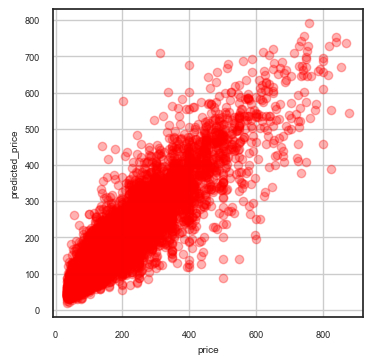

In [ ]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred, color='red', alpha=0.3)
plt.xlabel('price')
plt.ylabel('predicted_price')
plt.grid(visible=True)
plt.show()

### 10.3 Get the feature importance

In [ ]:
# Get the features importance from the best
transformed_features = xgb_regressor.regressor_[:-1].get_feature_names_out()
features_names = np.array([f.split('__')[1] for f in transformed_features])
# selected_ind = np.where(xgb_regressor.regressor_.named_steps.selectpercentile.get_support() ==True)[0]
# selected_features= features_names[selected_ind]

In [ ]:
importances = xgb_regressor.regressor_['xgbregressor'].feature_importances_
xgb_importances = pd.Series(importances, index=features_names).sort_values(ascending=False)

In [ ]:
len(xgb_regressor.regressor_['xgbregressor'].feature_importances_)

104

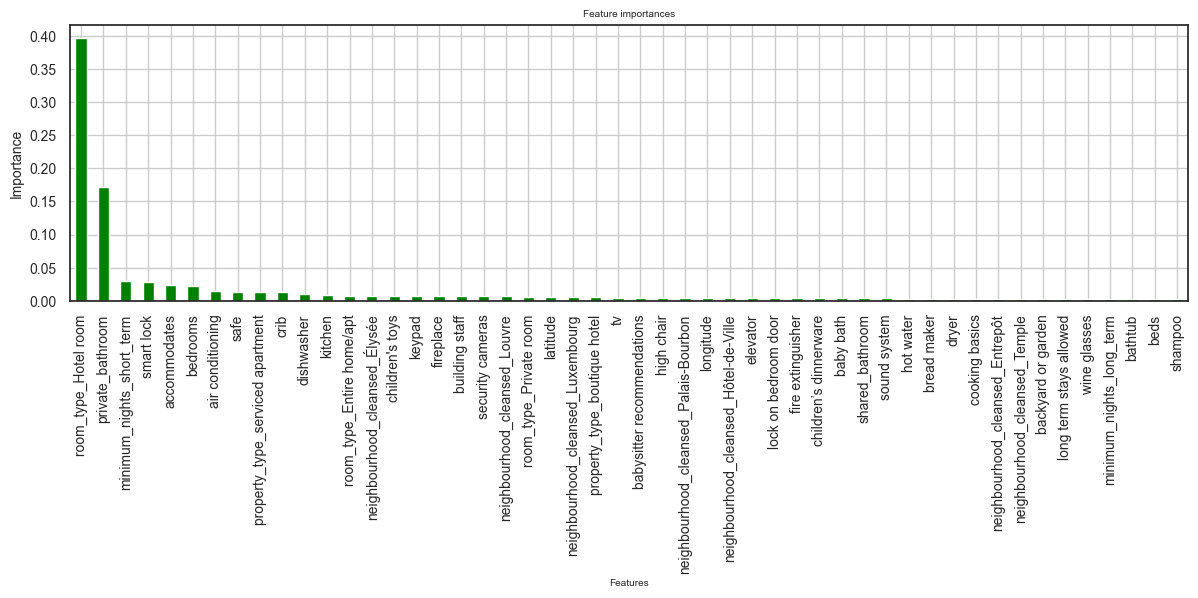

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
xgb_importances[:50].plot.bar(ax=ax, color='Green', fontsize=10)
ax.set_title("Feature importances")
ax.set_ylabel("Importance", fontsize=10)
ax.set_xlabel("Features")
ax.grid()
fig.tight_layout()
plt.show()
save_plot('feature_importances', x='Features', y='Importances')

---
10 Most important features

---
- room_type_Hotel room,
- private_bathroom
- minimum_nights_short_term
- smart lock
- accommodates
- bedrooms
- air conditioning
- safe
- property_type_serviced apartment
- crib



In [ ]:
grid_results = pd.DataFrame(search.cv_results_)
grid_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     141.504919     18.657192         0.353988        0.049528   
1     174.756975      3.296451         0.289022        0.008294   
2     194.865017      9.034986         0.304745        0.025415   
3     169.917869      7.666959         0.307560        0.020909   
4     170.682199     14.197776         0.286692        0.025026   

  param_regressor__xgbregressor__learning_rate  \
0                                          0.3   
1                                          0.3   
2                                          0.3   
3                                          0.3   
4                                          0.3   

  param_regressor__xgbregressor__max_depth  \
0                                        8   
1                                        8   
2                                        8   
3                                       10   
4                                       10   

  param_regressor__xgbregressor__n_estimators  \
0                                         500   
1                                         800   
2                                        1000   
3                                         500   
4                                         800   

                                              params  split0_test_score  \
0  {'regressor__xgbregressor__learning_rate': 0.3...         -49.368996   
1  {'regressor__xgbregressor__learning_rate': 0.3...         -48.741707   
2  {'regressor__xgbregressor__learning_rate': 0.3...         -48.775345   
3  {'regressor__xgbregressor__learning_rate': 0.3...         -48.942528   
4  {'regressor__xgbregressor__learning_rate': 0.3...         -49.186962   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0         -50.589729         -48.977886         -50.079086         -49.617741   
1         -50.892719         -49.307575         -49.068409         -49.363155   
2         -50.624870         -48.872444         -48.500397         -48.466953   
3         -50.470940         -49.934052         -48.919289         -49.766014   
4         -50.960022         -49.267750         -49.888893         -49.724575   

   mean_test_score  std_test_score  rank_test_score  
0       -49.726688        0.560275               12  
1       -49.474713        0.742092                9  
2       -49.048002        0.803637                7  
3       -49.606564        0.598850               11  
4       -49.805640        0.635325               13

# 11. Explainability - XAI

In [237]:
import time
import copy
from tqdm import tqdm
from types import SimpleNamespace
import xgboost
from fasttreeshap import TreeExplainer, plots, initjs, summary_plot, force_plot, utils
import time
import copy


In [ ]:
 # Set verbosity to 0 for the newest xgboost version warning
xgboost.set_config(verbosity=0)

## 11.1 Prepare the data

We compute the shap number for each of the features with and without scaled values.

As per [SHAP documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Explaining%20a%20model%20that%20uses%20standardized%20features.html) "When explaining a model that uses standardized features it is often desirable to get explanations using the original input features (not their standardized versions)".

In [ ]:
xgb_regressor.regressor_[0]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist'),
                                                  Index(['scrape_id', 'host_is_superhost', 'host_identity_verified',
       'neighbourhood_cleansed', 'property_type', 'room_type',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'instant_bookable'],
      dtype='object'))])),
                ('minmaxscaler', MinMaxScaler()),
                ('selectpercentile',
                 SelectPercentile(percentile=50,
                                  score_func=<function mutual_info_regression at 0x7ff1565df8b0>))])

In [ ]:
#########   All transformations ############
y_test_trans = xgb_regressor.transformer_.transform(y_test.values.reshape(-1,1))
x_test_trans = xgb_regressor.regressor_[0].transform(X_test)
x_test_df = pd.DataFrame(x_test_trans, columns=features_names)

### 11.2 Shapley values

In [ ]:
from fasttreeshap import dependence_plot, decision_plot, plots
from types import SimpleNamespace

In [ ]:
# Create explainer and
explainer = TreeExplainer(xgb_regressor.regressor_[-1], n_jobs=8)
shap_values = explainer(x_test_df)

In [ ]:
ind = np.where(xgb_regressor.regressor_[0][-1].get_support() == True)[0]
rescaled_data = xgb_regressor.regressor_[0][1:].inverse_transform(shap_values.data)[:, ind]

In [ ]:
# Compute values proportions
shap_values_proportions = shap_values.values/shap_values.values.sum(axis=1).reshape(-1,1)

rescaled_base_value = xgb_regressor.transformer_.inverse_transform(shap_values.base_values)

rescaled_total_value = xgb_regressor.transformer_.inverse_transform(shap_values.base_values + shap_values.values.sum(axis=1).reshape(-1,1))

shap_rescaled_values = shap_values_proportions * (rescaled_total_value - rescaled_base_value)

In [ ]:
shap_values.values = shap_rescaled_values
shap_values.base_values = rescaled_base_value
shap_values.data = rescaled_data

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


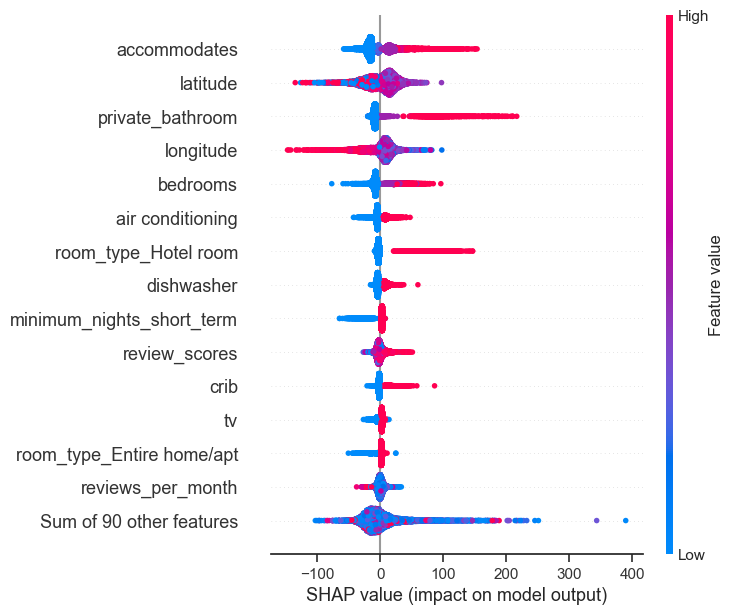

In [ ]:
# summarize the effects of all the features
plots.beeswarm(shap_values, max_display=15, plot_size=[6,7])

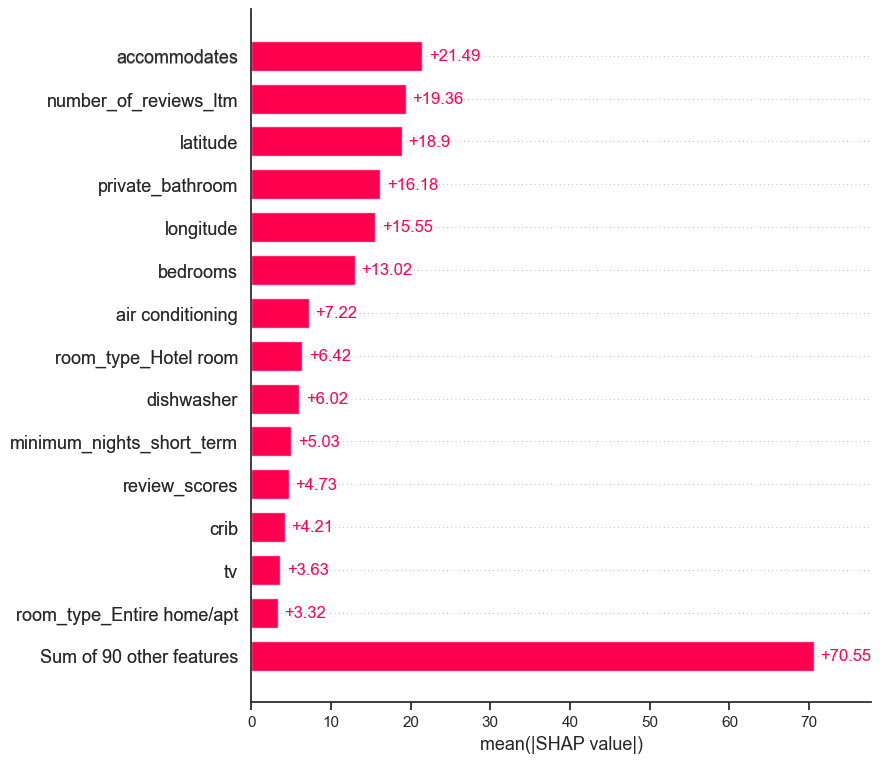

In [ ]:
plots.bar(shap_values, max_display=15)

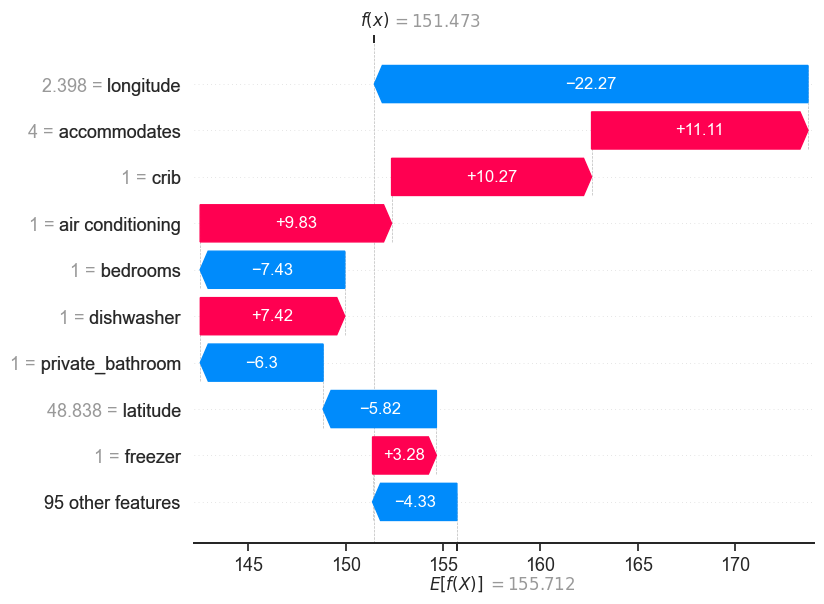

In [ ]:
to_pass = SimpleNamespace(**{'values':shap_values.values[876],
                          'data': shap_values.data[876],
                          'feature_names': x_test_df.columns,
                        'base_values': shap_values.base_values[876][0]})
plots.waterfall(to_pass, max_display=10)

In [ ]:
initjs()
force_plot(shap_values[876],  figsize=15)

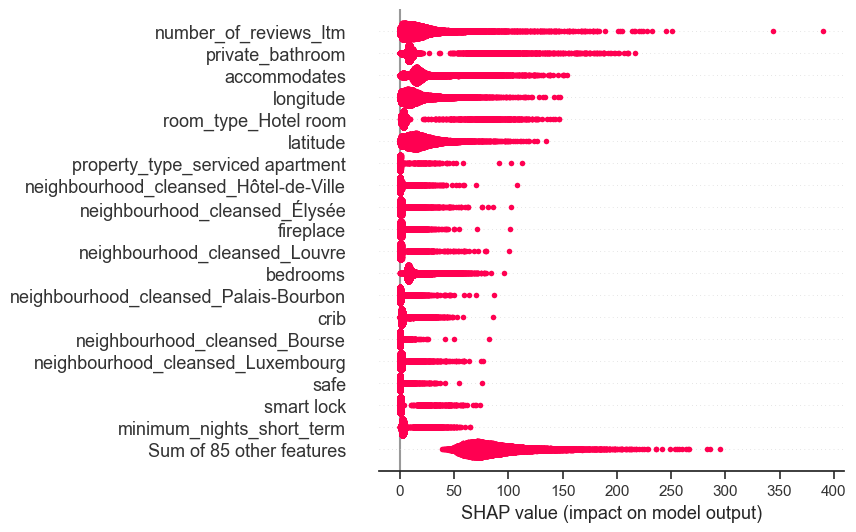

In [ ]:
plots.beeswarm(shap_values.abs, order=shap_values.abs.max(0), color="shap_red", max_display=20,
                           plot_size=[6,6])

In [ ]:
rng = np.random.default_rng(123)
idx = rng.integers(low=0, high=len(X_test), size=600)
initjs()
plots.force(shap_values.base_values[0], shap_values.values[idx[0:300]], feature_names=x_test_df.columns)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
105it [01:31,  1.01it/s]                                                           


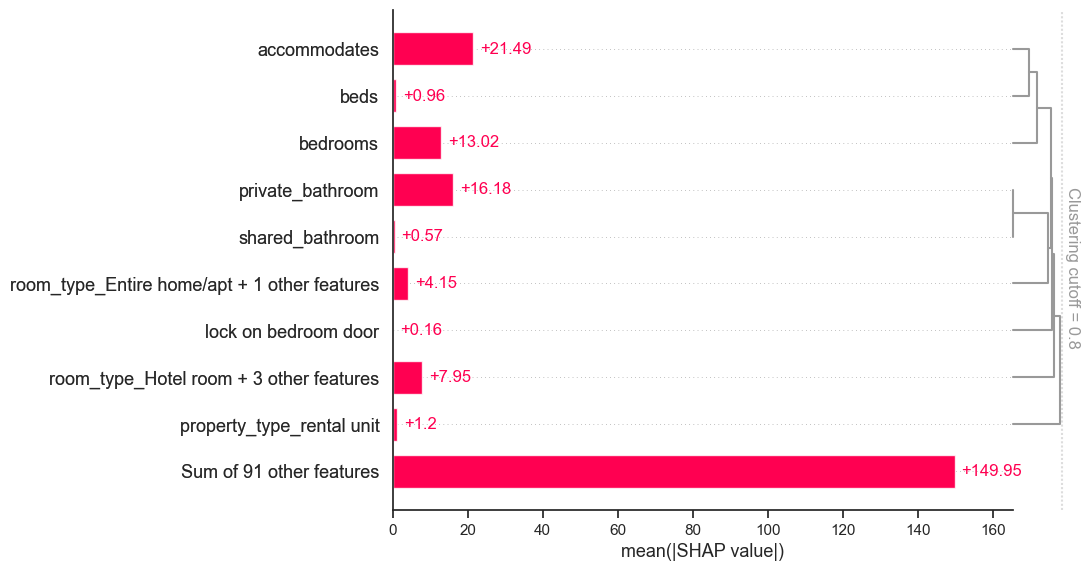

In [ ]:
clustering = utils.hclust(rescaled_data, y_test)
plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8, max_display=10)

### Largest contributors to the price (mean values contribution):

- **accommodates**
- **num_of_reviews**
- **latitude**
- **private bathroom**
- **longitude**

---


### Largest contributors to the price absolute value:

- **num_of_reviews_ltm**
- **private bathroom**
- **accommodates**
- **longitude**
- **room_type_Hotel room**
